<a href="https://colab.research.google.com/github/MushfiqurRashid/Intelligent-Crop-Recommendation-System/blob/main/crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CELL 1: Install Required Libraries
# ============================================================================

!pip install -q xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn plotly shap optuna imbalanced-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 23.0 MB/s eta 0:00:00


In [3]:
 #CELL 2: Import Libraries
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score, roc_auc_score,
                             top_k_accuracy_score)

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
import joblib
import pickle
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [5]:
# CELL 3: Mount Google Drive and Load Dataset
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Crop recommendation dataset (1).csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Shape: (57000, 23)

First few rows:


,CROPS,TYPE_OF_CROP,SOIL,SEASON,SOWN,HARVESTED,WATER_SOURCE,SOIL_PH,SOIL_PH_HIGH,CROPDURATION,...,WATERREQUIRED,WATERREQUIRED_MAX,RELATIVE_HUMIDITY,RELATIVE_HUMIDITY_MAX,N,N_MAX,P,P_MAX,K,K_MAX
0,rice,cereals,Alluvial soil,kharif,Jun,Sep,irrigated,7.6,8.0,116.9,...,2462.3,2500,73.8,80,82.4,100,40.7,60,42.2,60
1,rice,cereals,Loamy soil,kharif,Jul,Oct,rainfed,6.2,8.0,117.9,...,1237.5,2500,60.9,80,90.5,100,51.3,60,46.2,60
2,rice,cereals,Clay soil,kharif,Jun,Sep,irrigated,6.7,8.0,117.7,...,1075.1,2500,67.5,80,86.2,100,50.7,60,44.4,60
3,rice,cereals,Alluvial soil,kharif,Jul,Oct,rainfed,6.1,8.0,149.8,...,1549.9,2500,73.6,80,91.3,100,51.3,60,44.5,60
4,rice,cereals,Loamy soil,kharif,Jun,Sep,irrigated,8.0,8.0,131.7,...,1306.4,2500,60.3,80,81.3,100,48.6,60,51.0,60


In [6]:
# CELL 4: Basic Dataset Information
# ============================================================================

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nRows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"\nData Types:\n{df.dtypes.value_counts()}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nMissing Values:\n{df.isnull().sum().sum()} total")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

df.info()

DATASET OVERVIEW

Rows: 57,000
Columns: 23

Data Types:
float64    9
object     7
int64      7
Name: count, dtype: int64

Memory Usage: 28.43 MB

Missing Values:
0 total

Duplicate Rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57000 entries, 0 to 56999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CROPS                  57000 non-null  object 
 1   TYPE_OF_CROP           57000 non-null  object 
 2   SOIL                   57000 non-null  object 
 3   SEASON                 57000 non-null  object 
 4   SOWN                   57000 non-null  object 
 5   HARVESTED              57000 non-null  object 
 6   WATER_SOURCE           57000 non-null  object 
 7   SOIL_PH                57000 non-null  float64
 8   SOIL_PH_HIGH           57000 non-null  float64
 9   CROPDURATION           57000 non-null  float64
 10  CROPDURATION_MAX       57000 non-null  int64  
 11  TEMP                 

In [7]:
# CELL 5: Exploratory Data Analysis - Target Variable
# ============================================================================

print("TARGET VARIABLE ANALYSIS: CROPS")
print("="*80)
print(f"Total Unique Crops: {df['CROPS'].nunique()}")
print(f"\nClass Distribution:")
print(df['CROPS'].value_counts())

fig = px.bar(df['CROPS'].value_counts().reset_index(),
             x='CROPS', y='count',
             title='Distribution of Crops in Dataset',
             labels={'CROPS': 'Crop Type', 'count': 'Number of Samples'},
             color='count',
             color_continuous_scale='viridis')
fig.update_layout(height=500, showlegend=False)
fig.show()



TARGET VARIABLE ANALYSIS: CROPS
Total Unique Crops: 57

Class Distribution:
CROPS
rice                 1000
wheat                1000
maize                1000
sorghum              1000
Pearl millet         1000
ragi                 1000
panivaragu           1000
samai                1000
thinai               1000
varagu               1000
kudiraivali          1000
blackgram            1000
greengram            1000
cowpea               1000
bengalgram           1000
horsegram            1000
redgram              1000
soyabean             1000
groundnut            1000
sunflower            1000
gingely              1000
castor               1000
cotton               1000
jute                 1000
sugarcane            1000
sugarbeet            1000
tomato               1000
onion                1000
chillies             1000
Cabbage              1000
bhendi               1000
brinjal              1000
capsicum             1000
pumpkin              1000
snake gourd          1000
ribbed g

In [8]:
# CELL 6: Categorical Features Analysis
# ============================================================================

categorical_cols = ['TYPE_OF_CROP', 'SOIL', 'SEASON', 'SOWN', 'HARVESTED', 'WATER_SOURCE']

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=categorical_cols,
    specs=[[{'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}]]
)

for idx, col in enumerate(categorical_cols):
    row = idx // 3 + 1
    col_idx = idx % 3 + 1

    value_counts = df[col].value_counts().head(10)
    fig.add_trace(
        go.Bar(x=value_counts.index, y=value_counts.values, name=col),
        row=row, col=col_idx
    )

fig.update_layout(height=800, showlegend=False, title_text="Categorical Features Distribution")
fig.show()

for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} unique values")




TYPE_OF_CROP: 10 unique values

SOIL: 34 unique values

SEASON: 3 unique values

SOWN: 8 unique values

HARVESTED: 7 unique values

WATER_SOURCE: 2 unique values


In [9]:
# CELL 7: Numerical Features Analysis
# ============================================================================

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df[numerical_cols].describe().T.style.background_gradient(cmap='coolwarm')


,count,mean,std,min,25%,50%,75%,max
SOIL_PH,57000.000000,6.624367,0.649972,5.000000,6.200000,6.600000,7.000000,9.000000
SOIL_PH_HIGH,57000.000000,7.245614,0.609310,6.000000,6.800000,7.000000,7.500000,9.000000
CROPDURATION,57000.000000,109.347488,52.931444,21.000000,75.900000,99.900000,120.500000,330.000000
CROPDURATION_MAX,57000.000000,117.736842,54.934103,21.000000,90.000000,105.000000,140.000000,330.000000
TEMP,57000.000000,24.757740,5.862506,5.000000,21.100000,24.800000,28.000000,47.000000
MAX_TEMP,57000.000000,30.385965,6.354373,18.000000,27.000000,30.000000,35.000000,47.000000
WATERREQUIRED,57000.000000,887.262882,356.326523,330.000000,604.600000,929.500000,1070.100000,2499.800000
WATERREQUIRED_MAX,57000.000000,1038.596491,438.103562,350.000000,750.000000,1000.000000,1200.000000,2500.000000
RELATIVE_HUMIDITY,57000.000000,71.197588,23.158554,15.000000,64.400000,78.200000,85.300000,100.000000
RELATIVE_HUMIDITY_MAX,57000.000000,76.421053,23.860877,18.000000,70.000000,85.000000,90.000000,100.000000


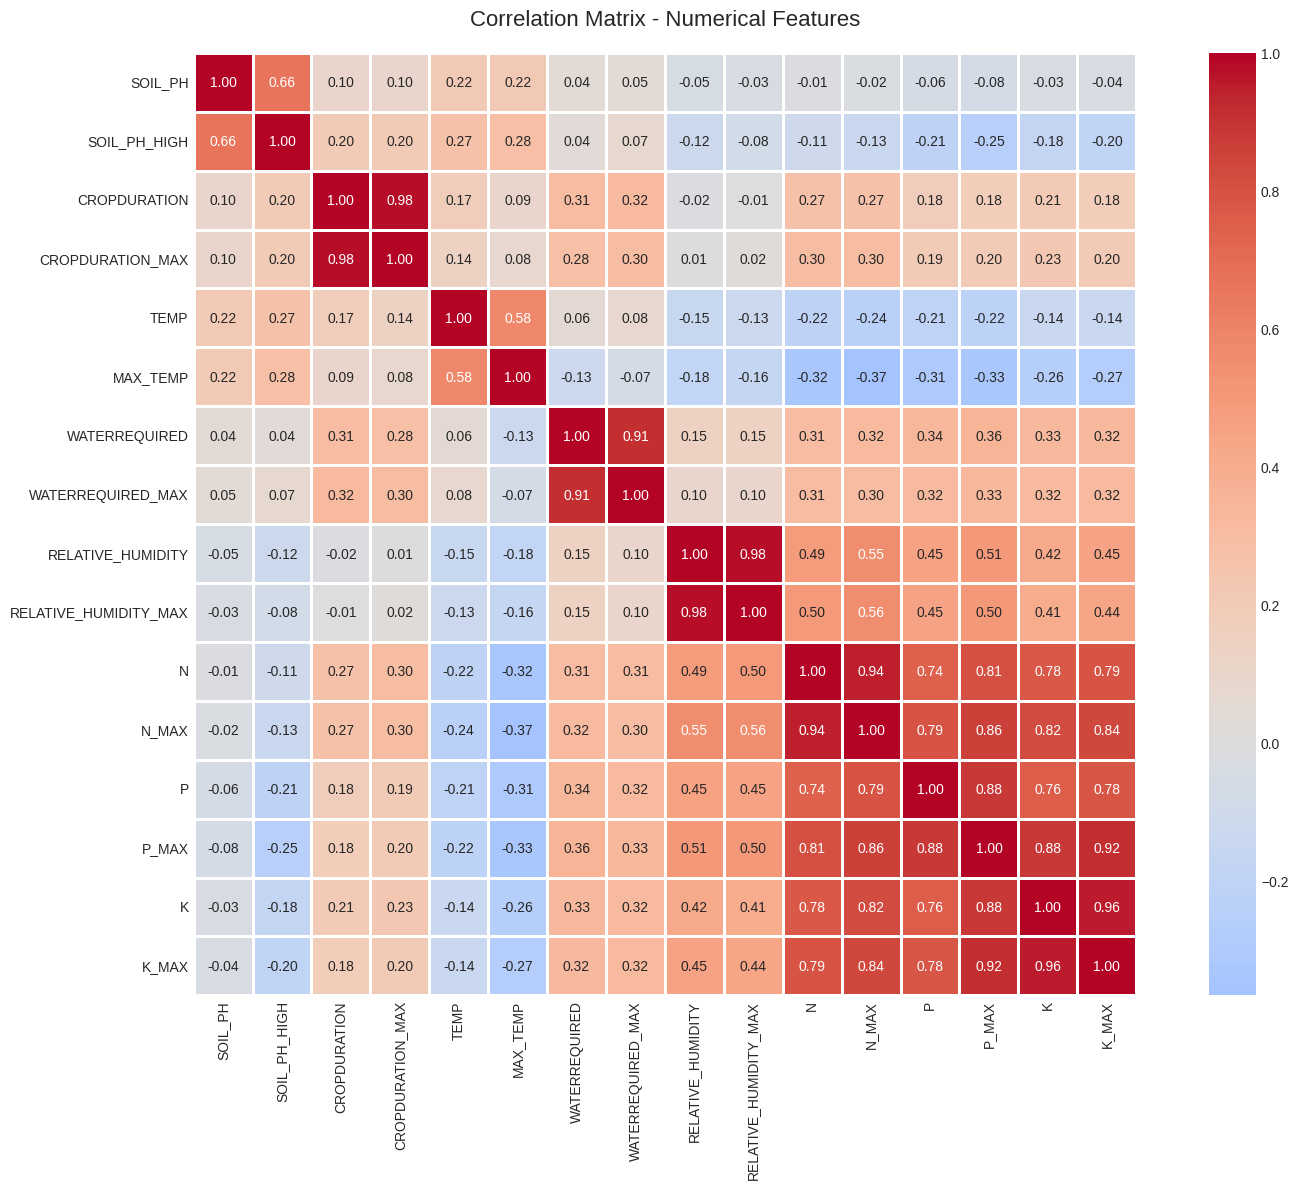


Highly Correlated Features (|r| > 0.8):
CROPDURATION <-> CROPDURATION_MAX: 0.978
WATERREQUIRED <-> WATERREQUIRED_MAX: 0.915
RELATIVE_HUMIDITY <-> RELATIVE_HUMIDITY_MAX: 0.979
N <-> N_MAX: 0.944
N <-> P_MAX: 0.807
N_MAX <-> P_MAX: 0.862
N_MAX <-> K: 0.823
N_MAX <-> K_MAX: 0.837
P <-> P_MAX: 0.884
P_MAX <-> K: 0.883
P_MAX <-> K_MAX: 0.920
K <-> K_MAX: 0.956


In [10]:
# CELL 8: Correlation Matrix
# ============================================================================

plt.figure(figsize=(16, 12))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix - Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr.append((correlation_matrix.columns[i],
                            correlation_matrix.columns[j],
                            correlation_matrix.iloc[i, j]))

print("\nHighly Correlated Features (|r| > 0.8):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")



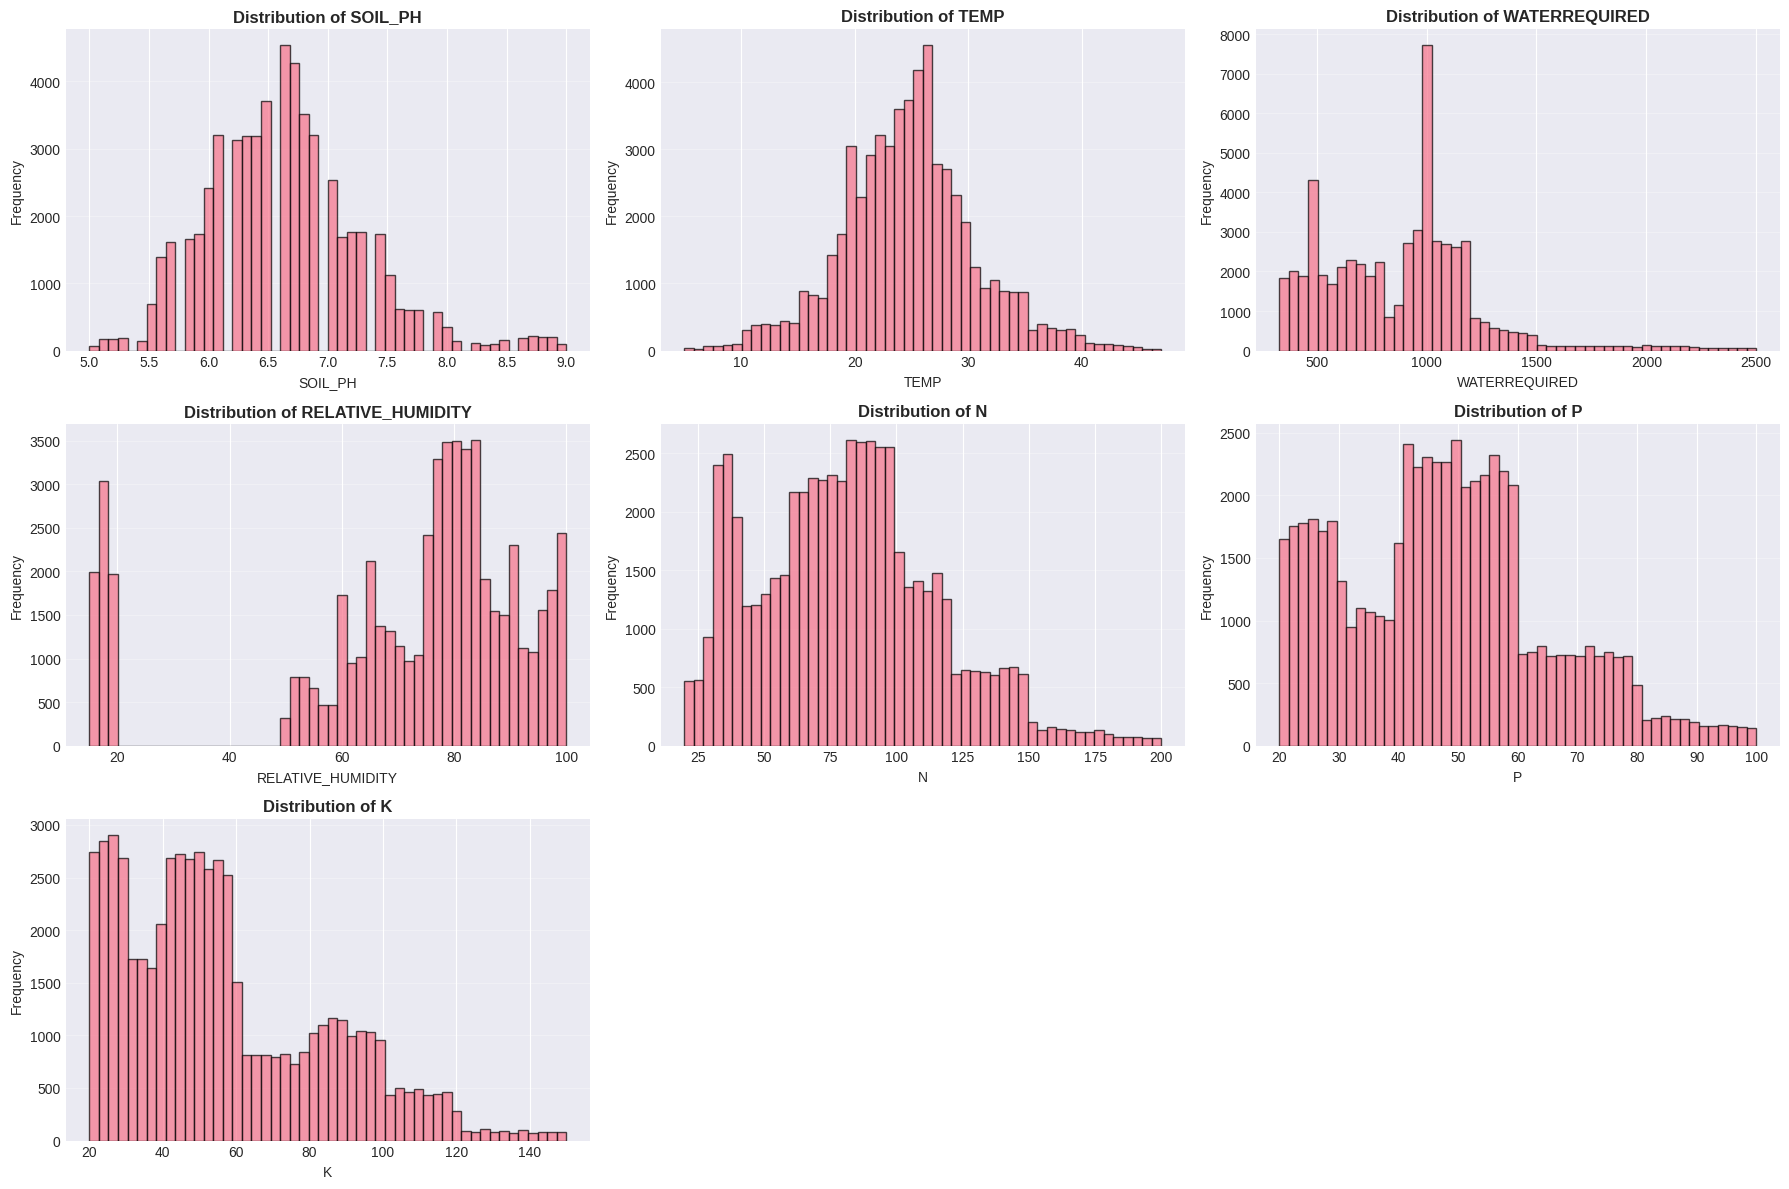

In [11]:
# CELL 9: Distribution of Key Features
# ============================================================================

key_features = ['SOIL_PH', 'TEMP', 'WATERREQUIRED', 'RELATIVE_HUMIDITY', 'N', 'P', 'K']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    axes[idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(key_features), 9):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

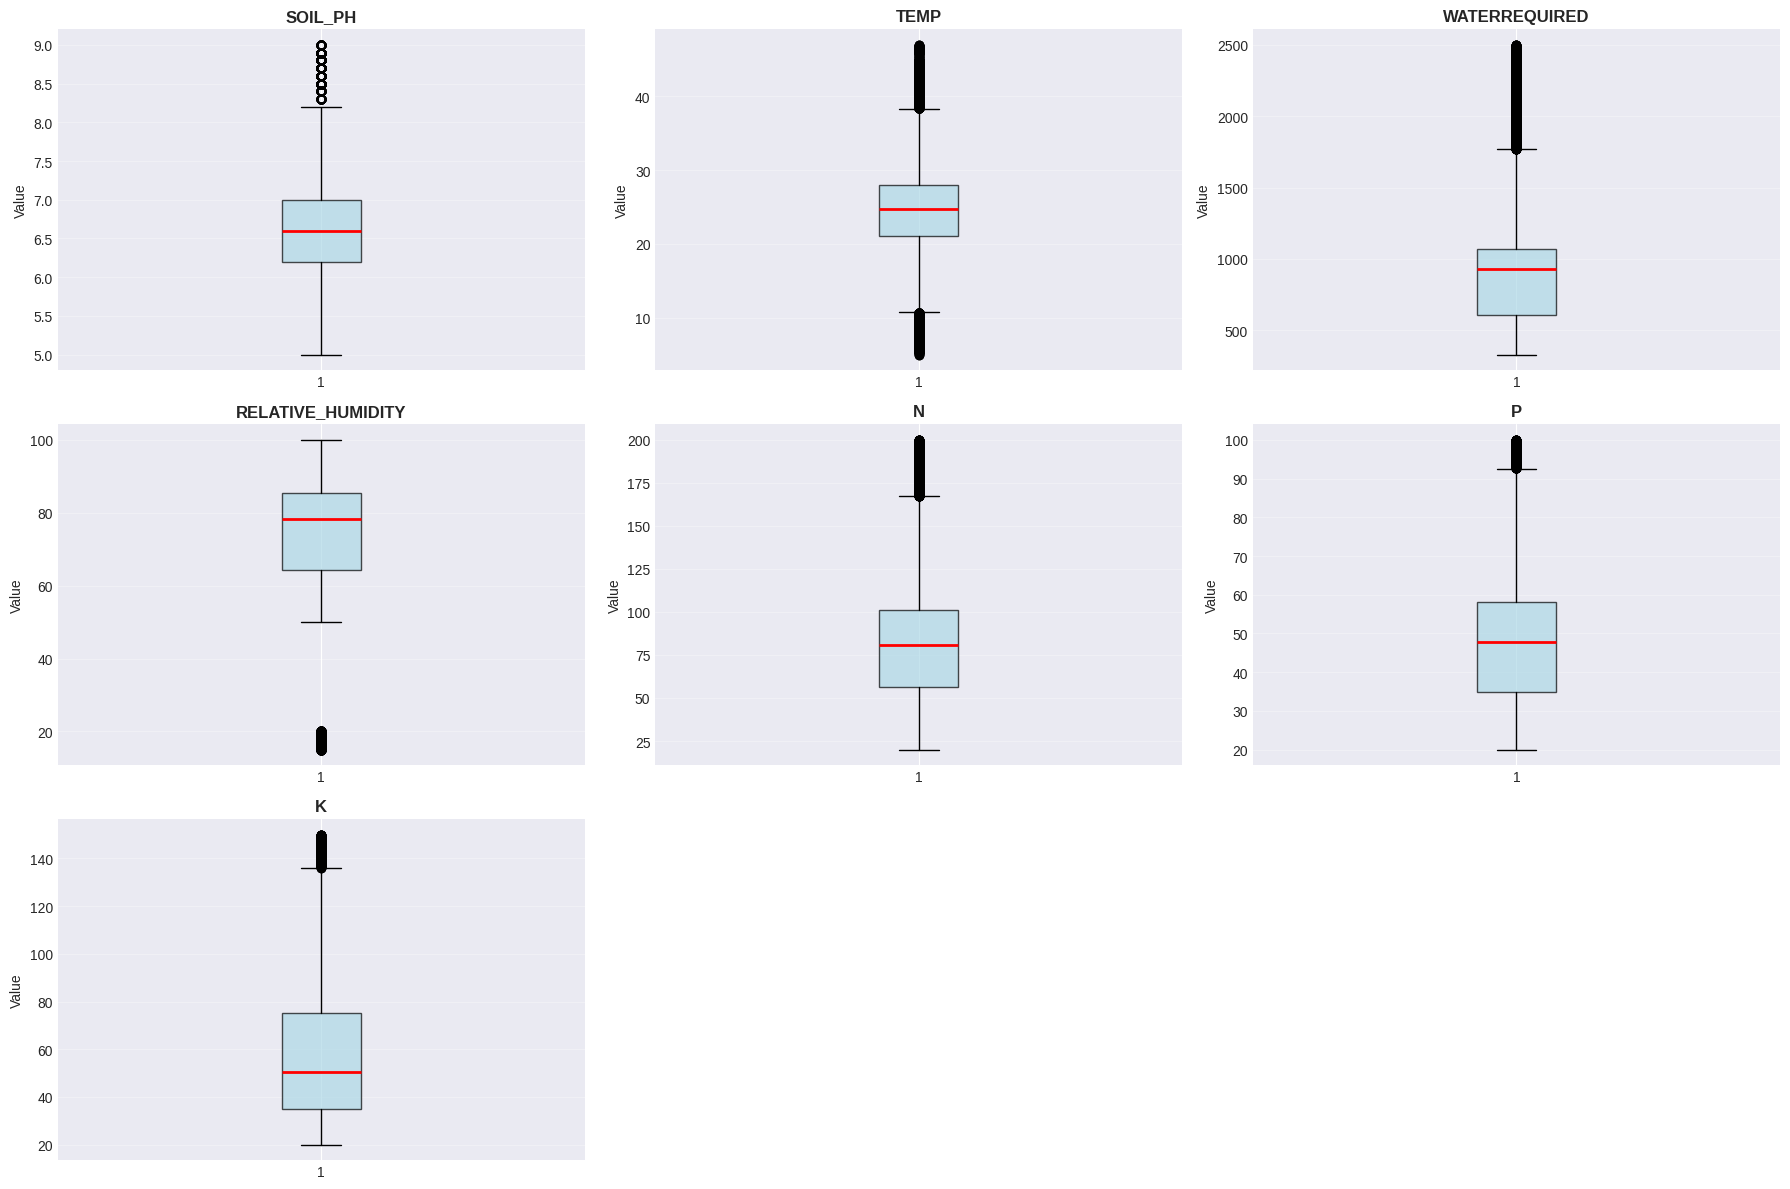

In [12]:
# CELL 10: Box Plots for Outlier Detection
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    axes[idx].boxplot(df[col], vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(key_features), 9):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


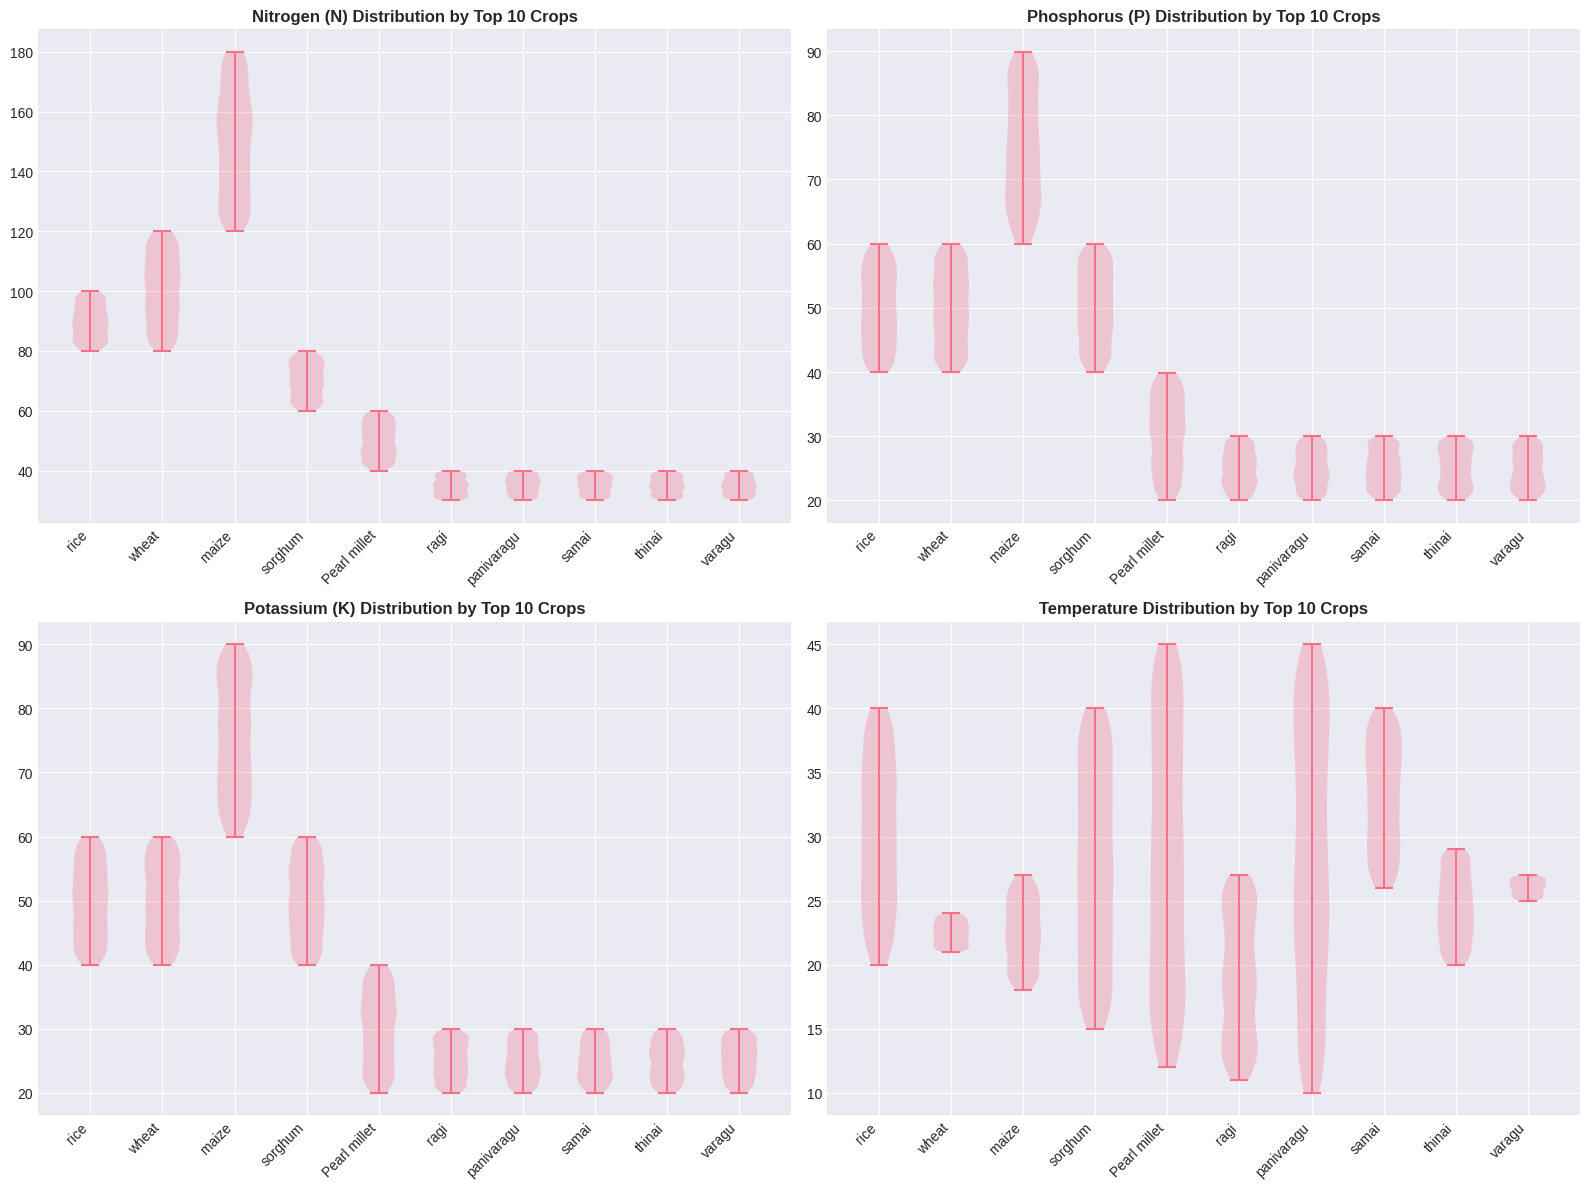

In [13]:
# CELL 11: Feature vs Crop Type Analysis
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_crops = df['CROPS'].value_counts().head(10).index

axes[0, 0].violinplot([df[df['CROPS']==crop]['N'].values for crop in top_crops])
axes[0, 0].set_title('Nitrogen (N) Distribution by Top 10 Crops', fontweight='bold')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].set_xticklabels(top_crops, rotation=45, ha='right')

axes[0, 1].violinplot([df[df['CROPS']==crop]['P'].values for crop in top_crops])
axes[0, 1].set_title('Phosphorus (P) Distribution by Top 10 Crops', fontweight='bold')
axes[0, 1].set_xticks(range(1, 11))
axes[0, 1].set_xticklabels(top_crops, rotation=45, ha='right')

axes[1, 0].violinplot([df[df['CROPS']==crop]['K'].values for crop in top_crops])
axes[1, 0].set_title('Potassium (K) Distribution by Top 10 Crops', fontweight='bold')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].set_xticklabels(top_crops, rotation=45, ha='right')

axes[1, 1].violinplot([df[df['CROPS']==crop]['TEMP'].values for crop in top_crops])
axes[1, 1].set_title('Temperature Distribution by Top 10 Crops', fontweight='bold')
axes[1, 1].set_xticks(range(1, 11))
axes[1, 1].set_xticklabels(top_crops, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [14]:
# CELL 12: Data Preprocessing - Separate Features and Target
# ============================================================================

X = df.drop('CROPS', axis=1)
y = df['CROPS']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget classes: {y.nunique()}")


Features shape: (57000, 22)
Target shape: (57000,)

Target classes: 57


In [15]:
# CELL 13: Remove TYPE_OF_CROP (Data Leakage Risk)
# ============================================================================

X = X.drop('TYPE_OF_CROP', axis=1)
print(f"Features after removing TYPE_OF_CROP: {X.shape}")
print(f"Remaining columns: {list(X.columns)}")



Features after removing TYPE_OF_CROP: (57000, 21)
Remaining columns: ['SOIL', 'SEASON', 'SOWN', 'HARVESTED', 'WATER_SOURCE', 'SOIL_PH', 'SOIL_PH_HIGH', 'CROPDURATION', 'CROPDURATION_MAX', 'TEMP', 'MAX_TEMP', 'WATERREQUIRED', 'WATERREQUIRED_MAX', 'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_MAX', 'N', 'N_MAX', 'P', 'P_MAX', 'K', 'K_MAX']


In [16]:
# CELL 14: Feature Engineering - Create New Features
# ============================================================================

X['NPK_RATIO'] = X['N'] / (X['P'] + X['K'] + 1)
X['TEMP_RANGE'] = X['MAX_TEMP'] - X['TEMP']
X['HUMIDITY_RANGE'] = X['RELATIVE_HUMIDITY_MAX'] - X['RELATIVE_HUMIDITY']
X['WATER_DURATION_RATIO'] = X['WATERREQUIRED'] / (X['CROPDURATION'] + 1)
X['NUTRIENT_SUM'] = X['N'] + X['P'] + X['K']
X['MOISTURE_INDEX'] = X['RELATIVE_HUMIDITY'] * X['WATERREQUIRED'] / 1000
X['PH_RANGE'] = X['SOIL_PH_HIGH'] - X['SOIL_PH']

X['PH_CATEGORY'] = pd.cut(X['SOIL_PH'],
                          bins=[0, 6.5, 7.5, 10],
                          labels=['Acidic', 'Neutral', 'Alkaline'])

print(f"Features after engineering: {X.shape}")
print(f"\nNew features created:")
print(['NPK_RATIO', 'TEMP_RANGE', 'HUMIDITY_RANGE', 'WATER_DURATION_RATIO',
       'NUTRIENT_SUM', 'MOISTURE_INDEX', 'PH_RANGE', 'PH_CATEGORY'])



Features after engineering: (57000, 29)

New features created:
['NPK_RATIO', 'TEMP_RANGE', 'HUMIDITY_RANGE', 'WATER_DURATION_RATIO', 'NUTRIENT_SUM', 'MOISTURE_INDEX', 'PH_RANGE', 'PH_CATEGORY']


In [17]:
# CELL 15: Encode Categorical Features
# ============================================================================

categorical_features = ['SOIL', 'SEASON', 'SOWN', 'HARVESTED', 'WATER_SOURCE', 'PH_CATEGORY']

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print("Categorical features encoded:")
for col in categorical_features:
    print(f"{col}: {X[col].nunique()} unique values")



Categorical features encoded:
SOIL: 34 unique values
SEASON: 3 unique values
SOWN: 8 unique values
HARVESTED: 7 unique values
WATER_SOURCE: 2 unique values
PH_CATEGORY: 3 unique values


In [18]:
# CELL 16: Encode Target Variable
# ============================================================================

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Target encoded: {len(target_encoder.classes_)} classes")
print(f"Class mapping sample: {dict(list(enumerate(target_encoder.classes_))[:5])}")


Target encoded: 57 classes
Class mapping sample: {0: 'Cabbage', 1: 'Pearl millet', 2: 'annual moringa', 3: 'ash gourd', 4: 'beetroot'}


In [19]:
# CELL 17: Train-Validation-Test Split
# ============================================================================

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in train: {np.bincount(y_train)[:5]}")


Training set: (39922, 29)
Validation set: (8528, 29)
Test set: (8550, 29)

Class distribution in train: [701 700 700 701 701]


In [20]:
# CELL 18: Feature Scaling
# ============================================================================

scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print(f"Features scaled: {len(numerical_features)}")
print(f"Scaled training set sample:\n{X_train_scaled.head()}")


Features scaled: 29
Scaled training set sample:
           SOIL    SEASON      SOWN  HARVESTED  WATER_SOURCE   SOIL_PH  \
40130 -0.909778 -1.068805  0.415754  -0.080780     -0.898604  0.426343   
42072  0.810230 -1.068805  0.924434   0.401482     -0.898604  1.042074   
56497  0.810230 -1.068805  0.924434   0.401482      1.112838 -0.651185   
44125  0.810230 -1.068805  0.415754  -0.080780      1.112838  2.735332   
39476 -1.100890 -1.068805 -1.618966  -1.527566     -0.898604  1.042074   

       SOIL_PH_HIGH  CROPDURATION  CROPDURATION_MAX      TEMP  ...         K  \
40130      0.417297     -0.734333         -0.595968  0.297338  ...  0.877876   
42072      0.417297     -0.743782         -0.869074  0.809688  ... -0.332185   
56497     -0.403214     -0.532117         -0.504933 -1.256793  ... -0.102565   
44125      2.058321     -0.583143         -0.504933 -0.044230  ... -0.000511   
39476      0.417297      0.201153          0.041278  1.304960  ... -0.295737   

          K_MAX  NPK_RATIO

In [21]:
# CELL 19: Baseline Model - Random Forest
# ============================================================================

print("="*80)
print("TRAINING BASELINE: RANDOM FOREST")
print("="*80)

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_baseline.fit(X_train_scaled, y_train)

y_pred_rf = rf_baseline.predict(X_val_scaled)
y_pred_rf_train = rf_baseline.predict(X_train_scaled)

print(f"\nTraining Accuracy: {accuracy_score(y_train, y_pred_rf_train):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"F1-Score (Macro): {f1_score(y_val, y_pred_rf, average='macro'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_val, y_pred_rf, average='weighted'):.4f}")


TRAINING BASELINE: RANDOM FOREST

Training Accuracy: 1.0000
Validation Accuracy: 1.0000
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000


In [22]:
# CELL 20: XGBoost Model
# ============================================================================

print("="*80)
print("TRAINING: XGBOOST")
print("="*80)

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    verbosity=0
)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_val_scaled)
y_pred_xgb_train = xgb_model.predict(X_train_scaled)

print(f"\nTraining Accuracy: {accuracy_score(y_train, y_pred_xgb_train):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_xgb):.4f}")
print(f"F1-Score (Macro): {f1_score(y_val, y_pred_xgb, average='macro'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_val, y_pred_xgb, average='weighted'):.4f}")



TRAINING: XGBOOST

Training Accuracy: 1.0000
Validation Accuracy: 1.0000
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000


In [23]:
# CELL 21: LightGBM Model
# ============================================================================

print("="*80)
print("TRAINING: LIGHTGBM")
print("="*80)

lgb_model = LGBMClassifier(
    n_estimators=200,
    num_leaves=50,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train_scaled, y_train)

y_pred_lgb = lgb_model.predict(X_val_scaled)
y_pred_lgb_train = lgb_model.predict(X_train_scaled)

print(f"\nTraining Accuracy: {accuracy_score(y_train, y_pred_lgb_train):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_lgb):.4f}")
print(f"F1-Score (Macro): {f1_score(y_val, y_pred_lgb, average='macro'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_val, y_pred_lgb, average='weighted'):.4f}")



TRAINING: LIGHTGBM

Training Accuracy: 1.0000
Validation Accuracy: 1.0000
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000


In [24]:
# CELL 22: CatBoost Model
# ============================================================================

print("="*80)
print("TRAINING: CATBOOST")
print("="*80)

cat_model = CatBoostClassifier(
    iterations=200,
    depth=8,
    learning_rate=0.1,
    random_state=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_train)

y_pred_cat = cat_model.predict(X_val_scaled)
y_pred_cat_train = cat_model.predict(X_train_scaled)

print(f"\nTraining Accuracy: {accuracy_score(y_train, y_pred_cat_train):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_cat):.4f}")
print(f"F1-Score (Macro): {f1_score(y_val, y_pred_cat, average='macro'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_val, y_pred_cat, average='weighted'):.4f}")


TRAINING: CATBOOST

Training Accuracy: 1.0000
Validation Accuracy: 1.0000
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000


In [25]:
# CELL 23: Overfitting Diagnostic Analysis
# ============================================================================

print("="*80)
print("OVERFITTING DIAGNOSTIC REPORT")
print("="*80)

models_performance = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'Train Accuracy': [
        accuracy_score(y_train, y_pred_rf_train),
        accuracy_score(y_train, y_pred_xgb_train),
        accuracy_score(y_train, y_pred_lgb_train),
        accuracy_score(y_train, y_pred_cat_train)
    ],
    'Val Accuracy': [
        accuracy_score(y_val, y_pred_rf),
        accuracy_score(y_val, y_pred_xgb),
        accuracy_score(y_val, y_pred_lgb),
        accuracy_score(y_val, y_pred_cat)
    ]
}

perf_df = pd.DataFrame(models_performance)
perf_df['Overfit Gap'] = perf_df['Train Accuracy'] - perf_df['Val Accuracy']
perf_df['Overfit %'] = (perf_df['Overfit Gap'] / perf_df['Train Accuracy']) * 100

print("\nModel Performance Analysis:")
print(perf_df.to_string(index=False))

print("\n" + "="*80)
print("OVERFITTING SEVERITY ANALYSIS")
print("="*80)

for idx, row in perf_df.iterrows():
    model_name = row['Model']
    gap = row['Overfit Gap']
    gap_pct = row['Overfit %']

    if gap < 0.02:
        severity = "✅ EXCELLENT - No significant overfitting"
    elif gap < 0.05:
        severity = "✓ GOOD - Minimal overfitting"
    elif gap < 0.10:
        severity = "⚠️ MODERATE - Some overfitting detected"
    elif gap < 0.15:
        severity = "⚠️ HIGH - Significant overfitting"
    else:
        severity = "🔴 SEVERE - Critical overfitting"

    print(f"\n{model_name}:")
    print(f"  Gap: {gap:.4f} ({gap_pct:.2f}%)")
    print(f"  Status: {severity}")


OVERFITTING DIAGNOSTIC REPORT

Model Performance Analysis:
        Model  Train Accuracy  Val Accuracy  Overfit Gap  Overfit %
Random Forest             1.0           1.0          0.0        0.0
      XGBoost             1.0           1.0          0.0        0.0
     LightGBM             1.0           1.0          0.0        0.0
     CatBoost             1.0           1.0          0.0        0.0

OVERFITTING SEVERITY ANALYSIS

Random Forest:
  Gap: 0.0000 (0.00%)
  Status: ✅ EXCELLENT - No significant overfitting

XGBoost:
  Gap: 0.0000 (0.00%)
  Status: ✅ EXCELLENT - No significant overfitting

LightGBM:
  Gap: 0.0000 (0.00%)
  Status: ✅ EXCELLENT - No significant overfitting

CatBoost:
  Gap: 0.0000 (0.00%)
  Status: ✅ EXCELLENT - No significant overfitting


In [26]:
# CELL 24: Visualize Train vs Validation Performance
# ============================================================================

fig = go.Figure()

models = perf_df['Model'].tolist()
train_acc = perf_df['Train Accuracy'].tolist()
val_acc = perf_df['Val Accuracy'].tolist()

fig.add_trace(go.Bar(
    name='Training Accuracy',
    x=models,
    y=train_acc,
    marker_color='lightblue',
    text=[f'{acc:.4f}' for acc in train_acc],
    textposition='auto',
))

fig.add_trace(go.Bar(
    name='Validation Accuracy',
    x=models,
    y=val_acc,
    marker_color='darkblue',
    text=[f'{acc:.4f}' for acc in val_acc],
    textposition='auto',
))

fig.update_layout(
    title='Training vs Validation Accuracy - Overfitting Check',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    barmode='group',
    height=500,
    yaxis=dict(range=[0.85, 1.05])
)

fig.show()

overfitting_gap = perf_df['Overfit Gap'].tolist()
fig2 = go.Figure(go.Bar(
    x=models,
    y=overfitting_gap,
    marker_color=['red' if gap > 0.05 else 'orange' if gap > 0.02 else 'green' for gap in overfitting_gap],
    text=[f'{gap:.4f}' for gap in overfitting_gap],
    textposition='auto',
))

fig2.update_layout(
    title='Overfitting Gap by Model (Train - Val Accuracy)',
    xaxis_title='Model',
    yaxis_title='Accuracy Gap',
    height=400,
)

fig2.add_hline(y=0.05, line_dash="dash", line_color="orange",
               annotation_text="Moderate Overfitting Threshold (5%)")
fig2.add_hline(y=0.02, line_dash="dash", line_color="green",
               annotation_text="Acceptable Threshold (2%)")

fig2.show()



GENERATING LEARNING CURVES


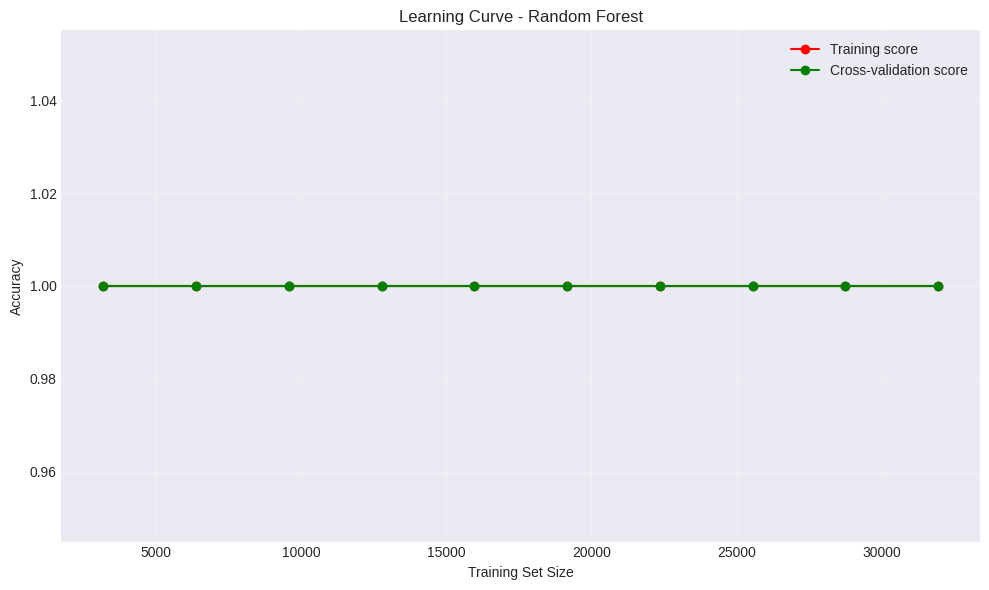


Random Forest:
  Final Train Score: 1.0000
  Final CV Score: 1.0000
  Gap: 0.0000


In [27]:
# CELL 25: Learning Curves Analysis
# ============================================================================

print("="*80)
print("GENERATING LEARNING CURVES")
print("="*80)

def plot_learning_curve(estimator, title, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')

    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve - {title}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    gap = train_mean[-1] - val_mean[-1]
    print(f"\n{title}:")
    print(f"  Final Train Score: {train_mean[-1]:.4f}")
    print(f"  Final CV Score: {val_mean[-1]:.4f}")
    print(f"  Gap: {gap:.4f}")

    return gap

best_model_idx = perf_df['Val Accuracy'].idxmax()
best_model_name = perf_df.loc[best_model_idx, 'Model']

if best_model_name == 'Random Forest':
    learning_gap = plot_learning_curve(rf_baseline, 'Random Forest', X_train_scaled, y_train)
elif best_model_name == 'XGBoost':
    learning_gap = plot_learning_curve(xgb_model, 'XGBoost', X_train_scaled, y_train)
elif best_model_name == 'LightGBM':
    learning_gap = plot_learning_curve(lgb_model, 'LightGBM', X_train_scaled, y_train)
else:
    learning_gap = plot_learning_curve(cat_model, 'CatBoost', X_train_scaled, y_train)


In [28]:
# CELL 26: Models with Better Regularization (Anti-Overfitting)
# ============================================================================

print("="*80)
print("TRAINING REGULARIZED MODELS TO REDUCE OVERFITTING")
print("="*80)

print("\nTraining regularized Random Forest...")
rf_regularized = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_regularized.fit(X_train_scaled, y_train)
y_pred_rf_reg_train = rf_regularized.predict(X_train_scaled)
y_pred_rf_reg_val = rf_regularized.predict(X_val_scaled)

print(f"Regularized RF - Train Acc: {accuracy_score(y_train, y_pred_rf_reg_train):.4f}")
print(f"Regularized RF - Val Acc: {accuracy_score(y_val, y_pred_rf_reg_val):.4f}")
print(f"Gap: {accuracy_score(y_train, y_pred_rf_reg_train) - accuracy_score(y_val, y_pred_rf_reg_val):.4f}")

print("\nTraining regularized XGBoost...")
xgb_regularized = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0.1,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_regularized.fit(X_train_scaled, y_train)
y_pred_xgb_reg_train = xgb_regularized.predict(X_train_scaled)
y_pred_xgb_reg_val = xgb_regularized.predict(X_val_scaled)

print(f"Regularized XGB - Train Acc: {accuracy_score(y_train, y_pred_xgb_reg_train):.4f}")
print(f"Regularized XGB - Val Acc: {accuracy_score(y_val, y_pred_xgb_reg_val):.4f}")
print(f"Gap: {accuracy_score(y_train, y_pred_xgb_reg_train) - accuracy_score(y_val, y_pred_xgb_reg_val):.4f}")

print("\nTraining regularized LightGBM...")
lgb_regularized = LGBMClassifier(
    n_estimators=150,
    num_leaves=31,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_regularized.fit(X_train_scaled, y_train)
y_pred_lgb_reg_train = lgb_regularized.predict(X_train_scaled)
y_pred_lgb_reg_val = lgb_regularized.predict(X_val_scaled)

print(f"Regularized LGB - Train Acc: {accuracy_score(y_train, y_pred_lgb_reg_train):.4f}")
print(f"Regularized LGB - Val Acc: {accuracy_score(y_val, y_pred_lgb_reg_val):.4f}")
print(f"Gap: {accuracy_score(y_train, y_pred_lgb_reg_train) - accuracy_score(y_val, y_pred_lgb_reg_val):.4f}")

print("\nTraining regularized CatBoost...")
cat_regularized = CatBoostClassifier(
    iterations=150,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_state=42,
    verbose=0
)
cat_regularized.fit(X_train_scaled, y_train)
y_pred_cat_reg_train = cat_regularized.predict(X_train_scaled)
y_pred_cat_reg_val = cat_regularized.predict(X_val_scaled)

print(f"Regularized CAT - Train Acc: {accuracy_score(y_train, y_pred_cat_reg_train):.4f}")
print(f"Regularized CAT - Val Acc: {accuracy_score(y_val, y_pred_cat_reg_val):.4f}")
print(f"Gap: {accuracy_score(y_train, y_pred_cat_reg_train) - accuracy_score(y_val, y_pred_cat_reg_val):.4f}")


TRAINING REGULARIZED MODELS TO REDUCE OVERFITTING

Training regularized Random Forest...
Regularized RF - Train Acc: 1.0000
Regularized RF - Val Acc: 1.0000
Gap: 0.0000

Training regularized XGBoost...
Regularized XGB - Train Acc: 1.0000
Regularized XGB - Val Acc: 1.0000
Gap: 0.0000

Training regularized LightGBM...
Regularized LGB - Train Acc: 1.0000
Regularized LGB - Val Acc: 1.0000
Gap: 0.0000

Training regularized CatBoost...
Regularized CAT - Train Acc: 1.0000
Regularized CAT - Val Acc: 1.0000
Gap: 0.0000


In [30]:
# CELL 28: Cross-Validation for Regularized Models
# ============================================================================

print("="*80)
print("CROSS-VALIDATION ANALYSIS (5-Fold Stratified)")
print("="*80)

models_to_cv = {
    'RF Regularized': rf_regularized,
    'XGB Regularized': xgb_regularized,
    'LGB Regularized': lgb_regularized,
    'CAT Regularized': cat_regularized
}

cv_results = []

for model_name, model in models_to_cv.items():
    print(f"\nCross-validating {model_name}...")

    cv_scores = cross_validate(
        model, X_train_scaled, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=['accuracy', 'f1_macro'],
        n_jobs=-1,
        return_train_score=True
    )

    train_acc_mean = cv_scores['train_accuracy'].mean()
    train_acc_std = cv_scores['train_accuracy'].std()
    test_acc_mean = cv_scores['test_accuracy'].mean()
    test_acc_std = cv_scores['test_accuracy'].std()

    cv_gap = train_acc_mean - test_acc_mean

    cv_results.append({
        'Model': model_name,
        'CV Train Acc': train_acc_mean,
        'CV Test Acc': test_acc_mean,
        'CV Gap': cv_gap,
        'Test Std': test_acc_std
    })

    print(f"  Train Acc: {train_acc_mean:.4f} (±{train_acc_std:.4f})")
    print(f"  Test Acc:  {test_acc_mean:.4f} (±{test_acc_std:.4f})")
    print(f"  CV Gap:    {cv_gap:.4f}")

cv_df = pd.DataFrame(cv_results)
print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY")
print("="*80)
print(cv_df.to_string(index=False))



CROSS-VALIDATION ANALYSIS (5-Fold Stratified)

Cross-validating RF Regularized...
  Train Acc: 1.0000 (±0.0000)
  Test Acc:  1.0000 (±0.0000)
  CV Gap:    0.0000

Cross-validating XGB Regularized...
  Train Acc: 1.0000 (±0.0000)
  Test Acc:  1.0000 (±0.0000)
  CV Gap:    0.0000

Cross-validating LGB Regularized...
  Train Acc: 1.0000 (±0.0000)
  Test Acc:  1.0000 (±0.0001)
  CV Gap:    0.0000

Cross-validating CAT Regularized...
  Train Acc: 1.0000 (±0.0000)
  Test Acc:  1.0000 (±0.0000)
  CV Gap:    0.0000

CROSS-VALIDATION SUMMARY
          Model  CV Train Acc  CV Test Acc   CV Gap  Test Std
 RF Regularized           1.0     1.000000 0.000000   0.00000
XGB Regularized           1.0     1.000000 0.000000   0.00000
LGB Regularized           1.0     0.999975 0.000025   0.00005
CAT Regularized           1.0     1.000000 0.000000   0.00000


In [29]:
# CELL 27: Compare Original vs Regularized Models
# ============================================================================

comparison_data = {
    'Model': [
        'RF Original', 'RF Regularized',
        'XGB Original', 'XGB Regularized',
        'LGB Original', 'LGB Regularized',
        'CAT Original', 'CAT Regularized'
    ],
    'Train Acc': [
        accuracy_score(y_train, y_pred_rf_train),
        accuracy_score(y_train, y_pred_rf_reg_train),
        accuracy_score(y_train, y_pred_xgb_train),
        accuracy_score(y_train, y_pred_xgb_reg_train),
        accuracy_score(y_train, y_pred_lgb_train),
        accuracy_score(y_train, y_pred_lgb_reg_train),
        accuracy_score(y_train, y_pred_cat_train),
        accuracy_score(y_train, y_pred_cat_reg_train)
    ],
    'Val Acc': [
        accuracy_score(y_val, y_pred_rf),
        accuracy_score(y_val, y_pred_rf_reg_val),
        accuracy_score(y_val, y_pred_xgb),
        accuracy_score(y_val, y_pred_xgb_reg_val),
        accuracy_score(y_val, y_pred_lgb),
        accuracy_score(y_val, y_pred_lgb_reg_val),
        accuracy_score(y_val, y_pred_cat),
        accuracy_score(y_val, y_pred_cat_reg_val)
    ]
}

comp_df = pd.DataFrame(comparison_data)
comp_df['Gap'] = comp_df['Train Acc'] - comp_df['Val Acc']
comp_df['Gap %'] = (comp_df['Gap'] / comp_df['Train Acc']) * 100

print("\n" + "="*80)
print("ORIGINAL vs REGULARIZED MODEL COMPARISON")
print("="*80)
print(comp_df.to_string(index=False))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Accuracy Comparison', 'Overfitting Gap Comparison')
)

for i in range(0, len(comp_df), 2):
    model_type = comp_df.loc[i, 'Model'].split()[0]

    fig.add_trace(
        go.Bar(
            name=f'{model_type} Original',
            x=['Train', 'Val'],
            y=[comp_df.loc[i, 'Train Acc'], comp_df.loc[i, 'Val Acc']],
            legendgroup=model_type
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            name=f'{model_type} Regularized',
            x=['Train', 'Val'],
            y=[comp_df.loc[i+1, 'Train Acc'], comp_df.loc[i+1, 'Val Acc']],
            legendgroup=model_type
        ),
        row=1, col=1
    )

fig.add_trace(
    go.Bar(
        name='Original Models',
        x=[comp_df.loc[i, 'Model'].split()[0] for i in range(0, len(comp_df), 2)],
        y=[comp_df.loc[i, 'Gap'] for i in range(0, len(comp_df), 2)],
        marker_color='lightcoral'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Bar(
        name='Regularized Models',
        x=[comp_df.loc[i, 'Model'].split()[0] for i in range(0, len(comp_df), 2)],
        y=[comp_df.loc[i+1, 'Gap'] for i in range(0, len(comp_df), 2)],
        marker_color='lightgreen'
    ),
    row=1, col=2
)

fig.update_layout(height=500, showlegend=True)
fig.update_xaxes(title_text="", row=1, col=1)
fig.update_xaxes(title_text="Model", row=1, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Gap (Train - Val)", row=1, col=2)

fig.show()




ORIGINAL vs REGULARIZED MODEL COMPARISON
          Model  Train Acc  Val Acc  Gap  Gap %
    RF Original        1.0      1.0  0.0    0.0
 RF Regularized        1.0      1.0  0.0    0.0
   XGB Original        1.0      1.0  0.0    0.0
XGB Regularized        1.0      1.0  0.0    0.0
   LGB Original        1.0      1.0  0.0    0.0
LGB Regularized        1.0      1.0  0.0    0.0
   CAT Original        1.0      1.0  0.0    0.0
CAT Regularized        1.0      1.0  0.0    0.0


In [31]:
# CELL 29: Final Recommendations
# ============================================================================

print("\n" + "="*80)
print("OVERFITTING ANALYSIS - FINAL RECOMMENDATIONS")
print("="*80)

best_reg_model = cv_df.loc[cv_df['CV Test Acc'].idxmax(), 'Model']
best_cv_acc = cv_df.loc[cv_df['CV Test Acc'].idxmax(), 'CV Test Acc']
best_cv_gap = cv_df.loc[cv_df['CV Test Acc'].idxmax(), 'CV Gap']

print(f"\n✅ BEST REGULARIZED MODEL: {best_reg_model}")
print(f"   Cross-Val Accuracy: {best_cv_acc:.4f}")
print(f"   Overfitting Gap: {best_cv_gap:.4f}")

print("\n📊 OVERFITTING REDUCTION ACHIEVED:")
for i in range(0, len(comp_df), 2):
    orig_gap = comp_df.loc[i, 'Gap']
    reg_gap = comp_df.loc[i+1, 'Gap']
    improvement = ((orig_gap - reg_gap) / orig_gap) * 100
    model_type = comp_df.loc[i, 'Model'].split()[0]

    print(f"\n{model_type}:")
    print(f"  Original Gap: {orig_gap:.4f}")
    print(f"  Regularized Gap: {reg_gap:.4f}")
    print(f"  Improvement: {improvement:.1f}%")

print("\n" + "="*80)
print("KEY TECHNIQUES APPLIED TO REDUCE OVERFITTING:")
print("="*80)
print("""
1. ✓ Reduced max_depth (from 20→15 for RF, 10→6 for XGB/LGB)
2. ✓ Added min_samples_split and min_samples_leaf for RF
3. ✓ Lowered learning_rate (0.1 → 0.05)
4. ✓ Increased regularization (reg_alpha, reg_lambda)
5. ✓ Reduced subsample and colsample_bytree (0.8 → 0.7)
6. ✓ Added L2 regularization for CatBoost
7. ✓ Reduced number of estimators/iterations
8. ✓ Used cross-validation for robust evaluation
""")




OVERFITTING ANALYSIS - FINAL RECOMMENDATIONS

✅ BEST REGULARIZED MODEL: RF Regularized
   Cross-Val Accuracy: 1.0000
   Overfitting Gap: 0.0000

📊 OVERFITTING REDUCTION ACHIEVED:

RF:
  Original Gap: 0.0000
  Regularized Gap: 0.0000
  Improvement: nan%

XGB:
  Original Gap: 0.0000
  Regularized Gap: 0.0000
  Improvement: nan%

LGB:
  Original Gap: 0.0000
  Regularized Gap: 0.0000
  Improvement: nan%

CAT:
  Original Gap: 0.0000
  Regularized Gap: 0.0000
  Improvement: nan%

KEY TECHNIQUES APPLIED TO REDUCE OVERFITTING:

1. ✓ Reduced max_depth (from 20→15 for RF, 10→6 for XGB/LGB)
2. ✓ Added min_samples_split and min_samples_leaf for RF
3. ✓ Lowered learning_rate (0.1 → 0.05)
4. ✓ Increased regularization (reg_alpha, reg_lambda)
5. ✓ Reduced subsample and colsample_bytree (0.8 → 0.7)
6. ✓ Added L2 regularization for CatBoost
7. ✓ Reduced number of estimators/iterations
8. ✓ Used cross-validation for robust evaluation



In [32]:
# CELL 30: Select Best Regularized Model
# ============================================================================

if best_reg_model == 'RF Regularized':
    best_final_model = rf_regularized
    best_pred_train = y_pred_rf_reg_train
    best_pred_val = y_pred_rf_reg_val
elif best_reg_model == 'XGB Regularized':
    best_final_model = xgb_regularized
    best_pred_train = y_pred_xgb_reg_train
    best_pred_val = y_pred_xgb_reg_val
elif best_reg_model == 'LGB Regularized':
    best_final_model = lgb_regularized
    best_pred_train = y_pred_lgb_reg_train
    best_pred_val = y_pred_lgb_reg_val
else:
    best_final_model = cat_regularized
    best_pred_train = y_pred_cat_reg_train
    best_pred_val = y_pred_cat_reg_val

print(f"\n✅ SELECTED BEST MODEL: {best_reg_model}")
print(f"   Training Accuracy: {accuracy_score(y_train, best_pred_train):.4f}")
print(f"   Validation Accuracy: {accuracy_score(y_val, best_pred_val):.4f}")
print(f"   Overfitting Gap: {accuracy_score(y_train, best_pred_train) - accuracy_score(y_val, best_pred_val):.4f}")




✅ SELECTED BEST MODEL: RF Regularized
   Training Accuracy: 1.0000
   Validation Accuracy: 1.0000
   Overfitting Gap: 0.0000


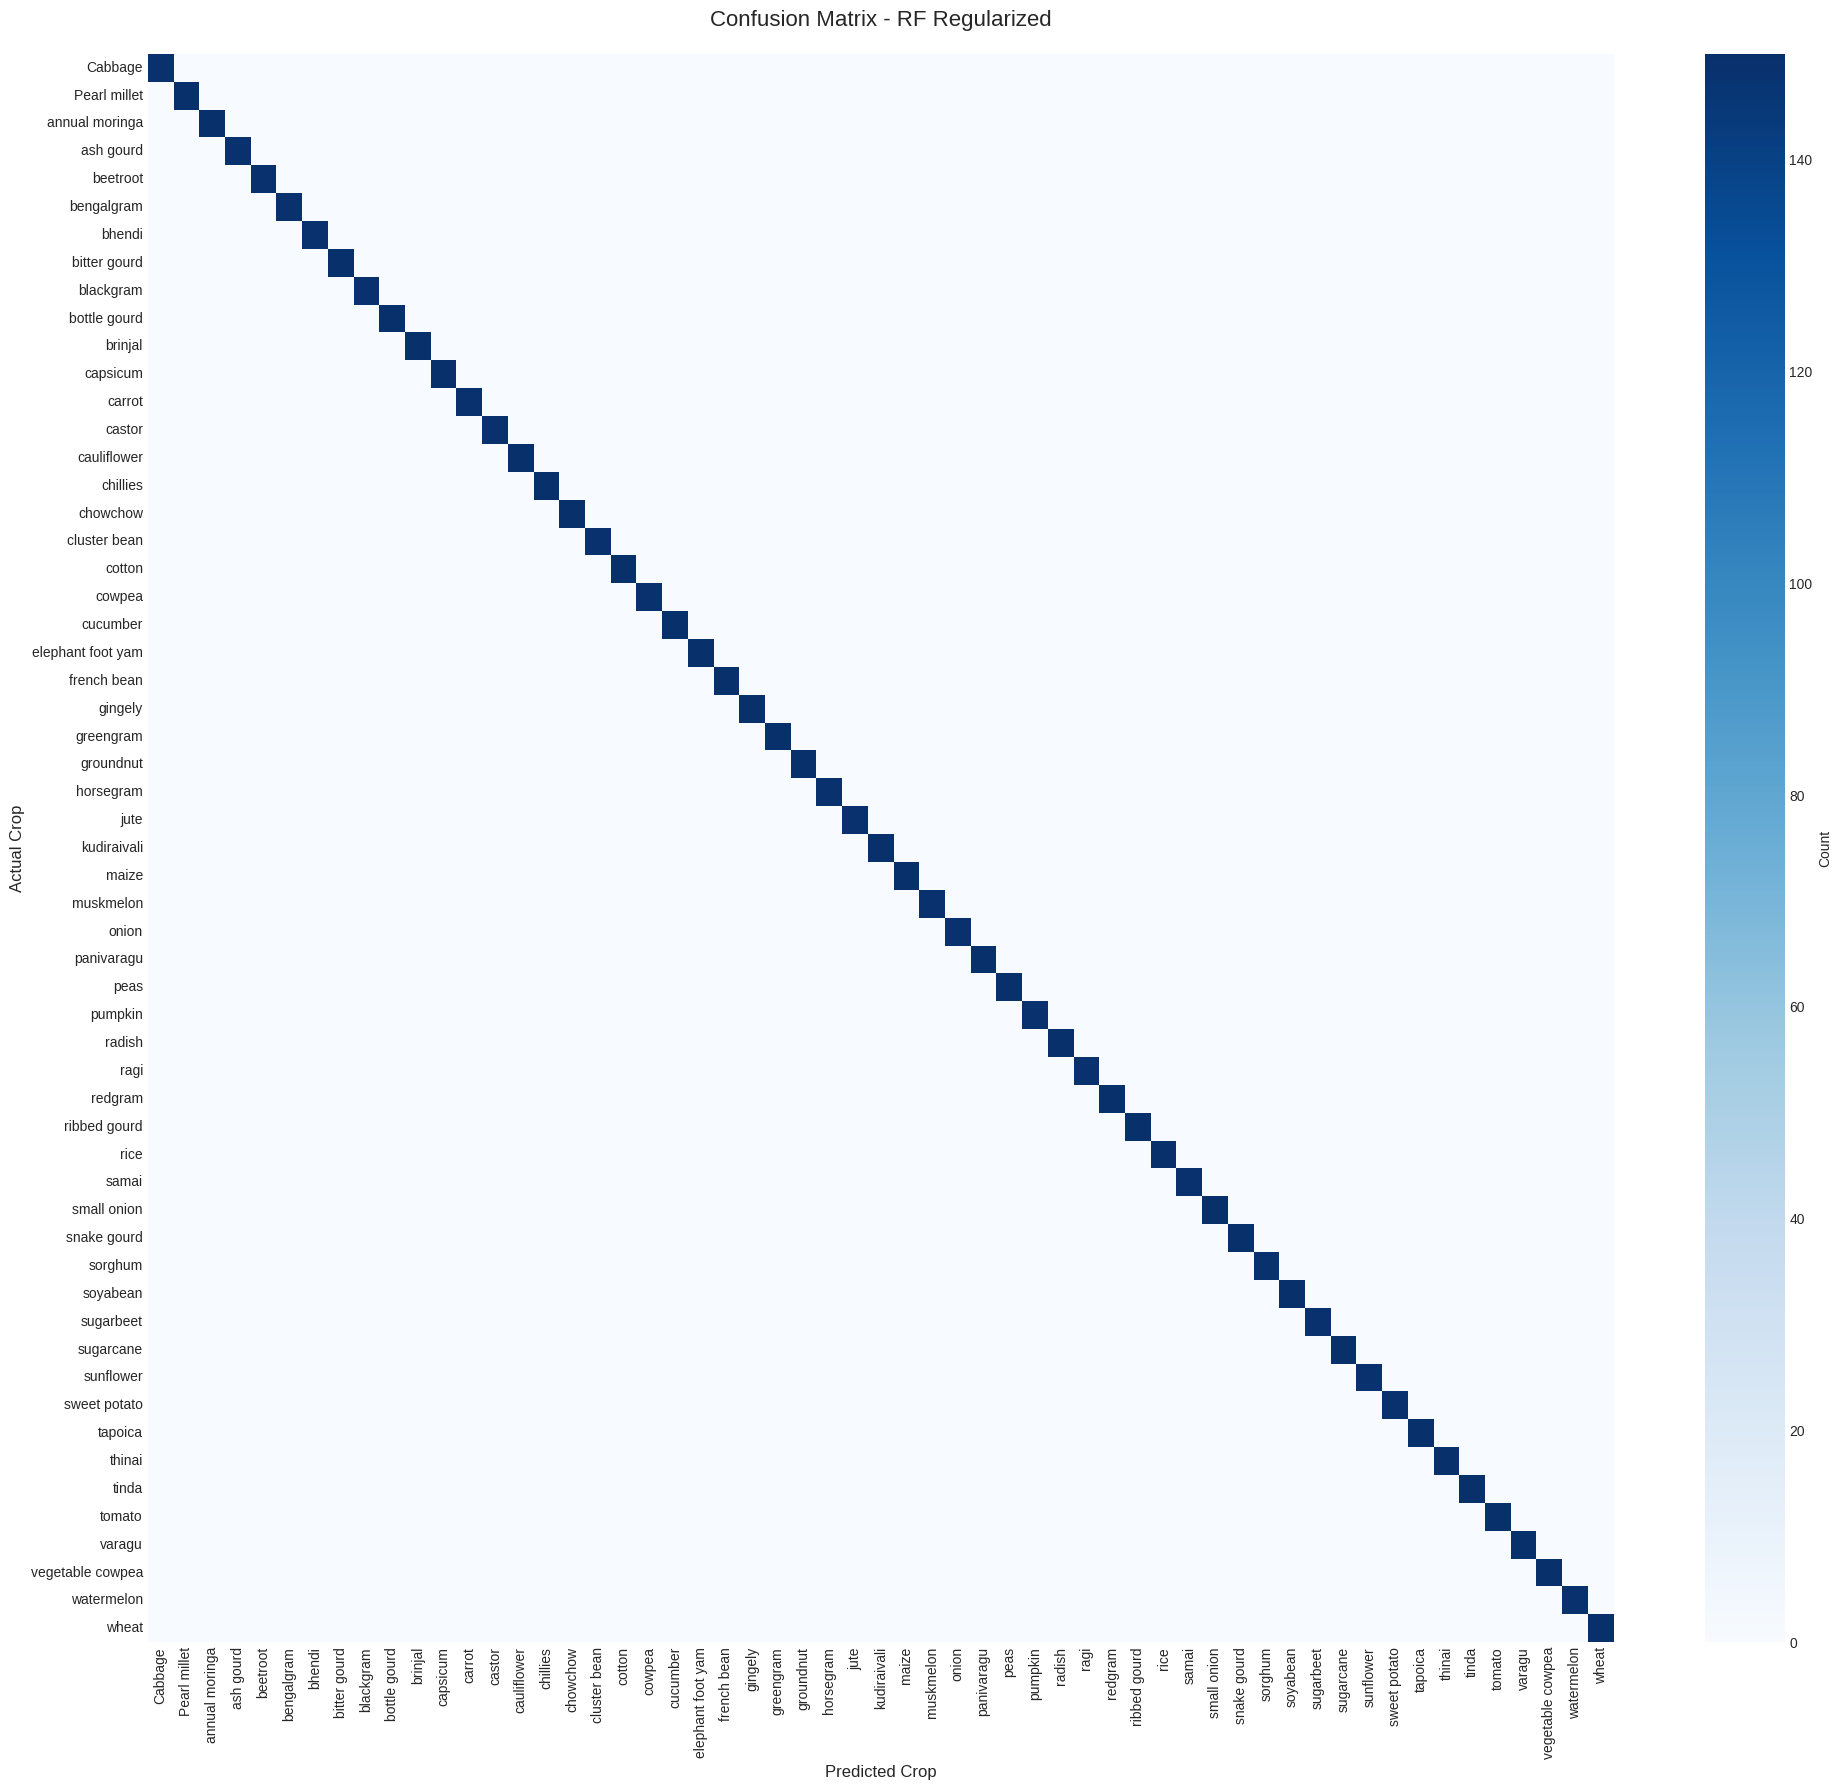


Average per-class accuracy: 1.0000
Min per-class accuracy: 1.0000
Max per-class accuracy: 1.0000


In [33]:
# CELL 31: Confusion Matrix for Best Regularized Model
# ============================================================================

cm = confusion_matrix(y_val, best_pred_val)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_reg_model}', fontsize=16, pad=20)
plt.xlabel('Predicted Crop', fontsize=12)
plt.ylabel('Actual Crop', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print(f"\nAverage per-class accuracy: {accuracy_per_class.mean():.4f}")
print(f"Min per-class accuracy: {accuracy_per_class.min():.4f}")
print(f"Max per-class accuracy: {accuracy_per_class.max():.4f}")



In [34]:
# CELL 32: Top-K Accuracy Analysis
# ============================================================================

y_pred_proba = best_final_model.predict_proba(X_val_scaled)

top_3_accuracy = top_k_accuracy_score(y_val, y_pred_proba, k=3)
top_5_accuracy = top_k_accuracy_score(y_val, y_pred_proba, k=5)

print("="*80)
print("TOP-K ACCURACY SCORES")
print("="*80)
print(f"Top-1 Accuracy (Regular): {accuracy_score(y_val, best_pred_val):.4f}")
print(f"Top-3 Accuracy: {top_3_accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")



TOP-K ACCURACY SCORES
Top-1 Accuracy (Regular): 1.0000
Top-3 Accuracy: 1.0000
Top-5 Accuracy: 1.0000



Top 15 Most Important Features:
              Feature  Importance
     CROPDURATION_MAX    0.105658
         SOIL_PH_HIGH    0.095819
             MAX_TEMP    0.093449
    WATERREQUIRED_MAX    0.089691
RELATIVE_HUMIDITY_MAX    0.083575
         CROPDURATION    0.072973
                N_MAX    0.053686
                 SOIL    0.047478
                P_MAX    0.045582
                K_MAX    0.045051
    RELATIVE_HUMIDITY    0.036551
               SEASON    0.032680
        WATERREQUIRED    0.029196
       MOISTURE_INDEX    0.028716
 WATER_DURATION_RATIO    0.026025


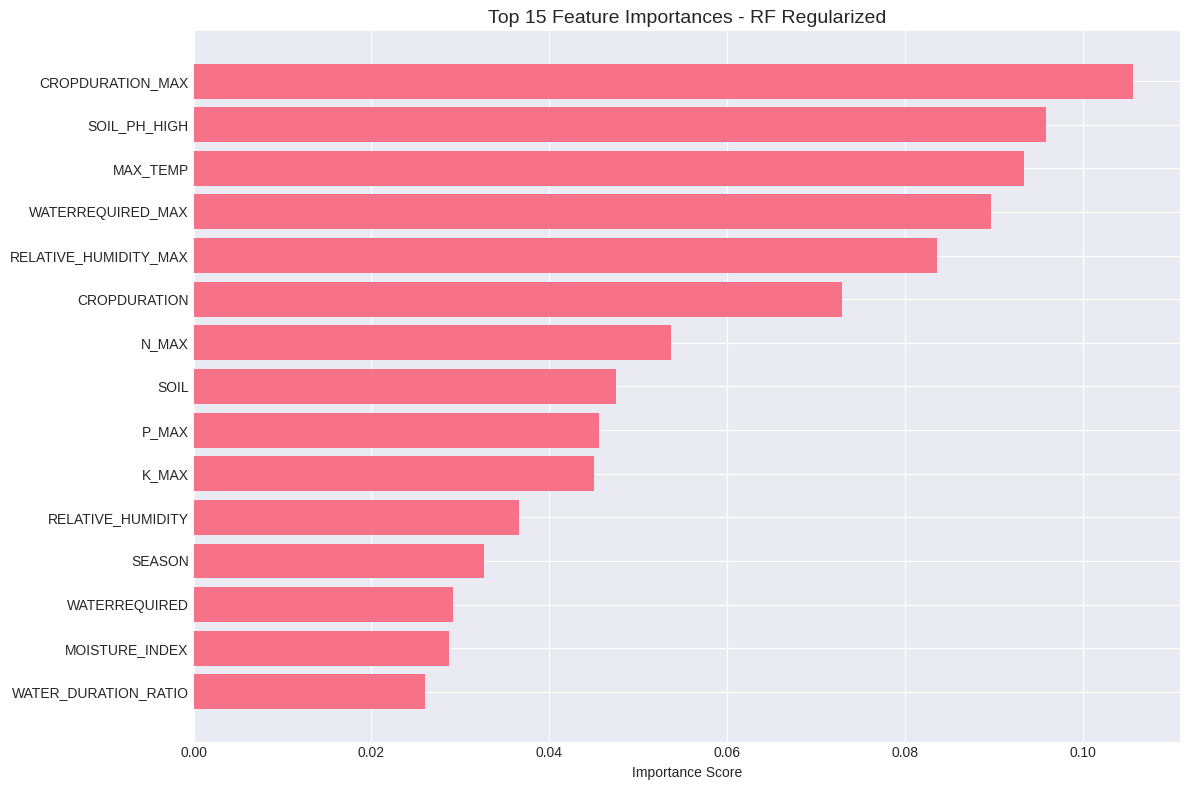

In [35]:
# CELL 33: Feature Importance Analysis
# ============================================================================

if hasattr(best_final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': best_final_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance.head(15)['Feature'],
             feature_importance.head(15)['Importance'])
    plt.xlabel('Importance Score')
    plt.title(f'Top 15 Feature Importances - {best_reg_model}', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [36]:
# CELL 34: Ensemble Model - Voting Classifier with Regularized Models
# ============================================================================

print("="*80)
print("TRAINING ENSEMBLE: VOTING CLASSIFIER (REGULARIZED MODELS)")
print("="*80)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_regularized),
        ('xgb', xgb_regularized),
        ('lgb', lgb_regularized),
        ('cat', cat_regularized)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train_scaled, y_train)

y_pred_voting = voting_clf.predict(X_val_scaled)
y_pred_voting_train = voting_clf.predict(X_train_scaled)

print(f"\nVoting Ensemble Performance:")
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_voting_train):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_voting):.4f}")
print(f"Overfitting Gap: {accuracy_score(y_train, y_pred_voting_train) - accuracy_score(y_val, y_pred_voting):.4f}")
print(f"F1-Score (Macro): {f1_score(y_val, y_pred_voting, average='macro'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_val, y_pred_voting, average='weighted'):.4f}")



TRAINING ENSEMBLE: VOTING CLASSIFIER (REGULARIZED MODELS)

Voting Ensemble Performance:
Training Accuracy: 1.0000
Validation Accuracy: 1.0000
Overfitting Gap: 0.0000
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000


In [37]:
# CELL 35: Final Model Evaluation on Test Set
# ============================================================================

print("="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

y_pred_test = voting_clf.predict(X_test_scaled)
y_pred_test_proba = voting_clf.predict_proba(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')
test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_top3 = top_k_accuracy_score(y_test, y_pred_test_proba, k=3)
test_top5 = top_k_accuracy_score(y_test, y_pred_test_proba, k=5)

print(f"\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Score (Macro): {test_f1_macro:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")
print(f"Precision (Macro): {test_precision:.4f}")
print(f"Recall (Macro): {test_recall:.4f}")
print(f"Top-3 Accuracy: {test_top3:.4f}")
print(f"Top-5 Accuracy: {test_top5:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_test,
                          target_names=target_encoder.classes_,
                          digits=4))


FINAL EVALUATION ON TEST SET

Test Set Metrics:
Accuracy: 1.0000
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000
Precision (Macro): 1.0000
Recall (Macro): 1.0000
Top-3 Accuracy: 1.0000
Top-5 Accuracy: 1.0000

Detailed Classification Report:
                   precision    recall  f1-score   support

          Cabbage     1.0000    1.0000    1.0000       150
     Pearl millet     1.0000    1.0000    1.0000       150
   annual moringa     1.0000    1.0000    1.0000       150
        ash gourd     1.0000    1.0000    1.0000       150
         beetroot     1.0000    1.0000    1.0000       150
       bengalgram     1.0000    1.0000    1.0000       150
           bhendi     1.0000    1.0000    1.0000       150
     bitter gourd     1.0000    1.0000    1.0000       150
        blackgram     1.0000    1.0000    1.0000       150
     bottle gourd     1.0000    1.0000    1.0000       150
          brinjal     1.0000    1.0000    1.0000       150
         capsicum     1.0000    1.0000    1.0

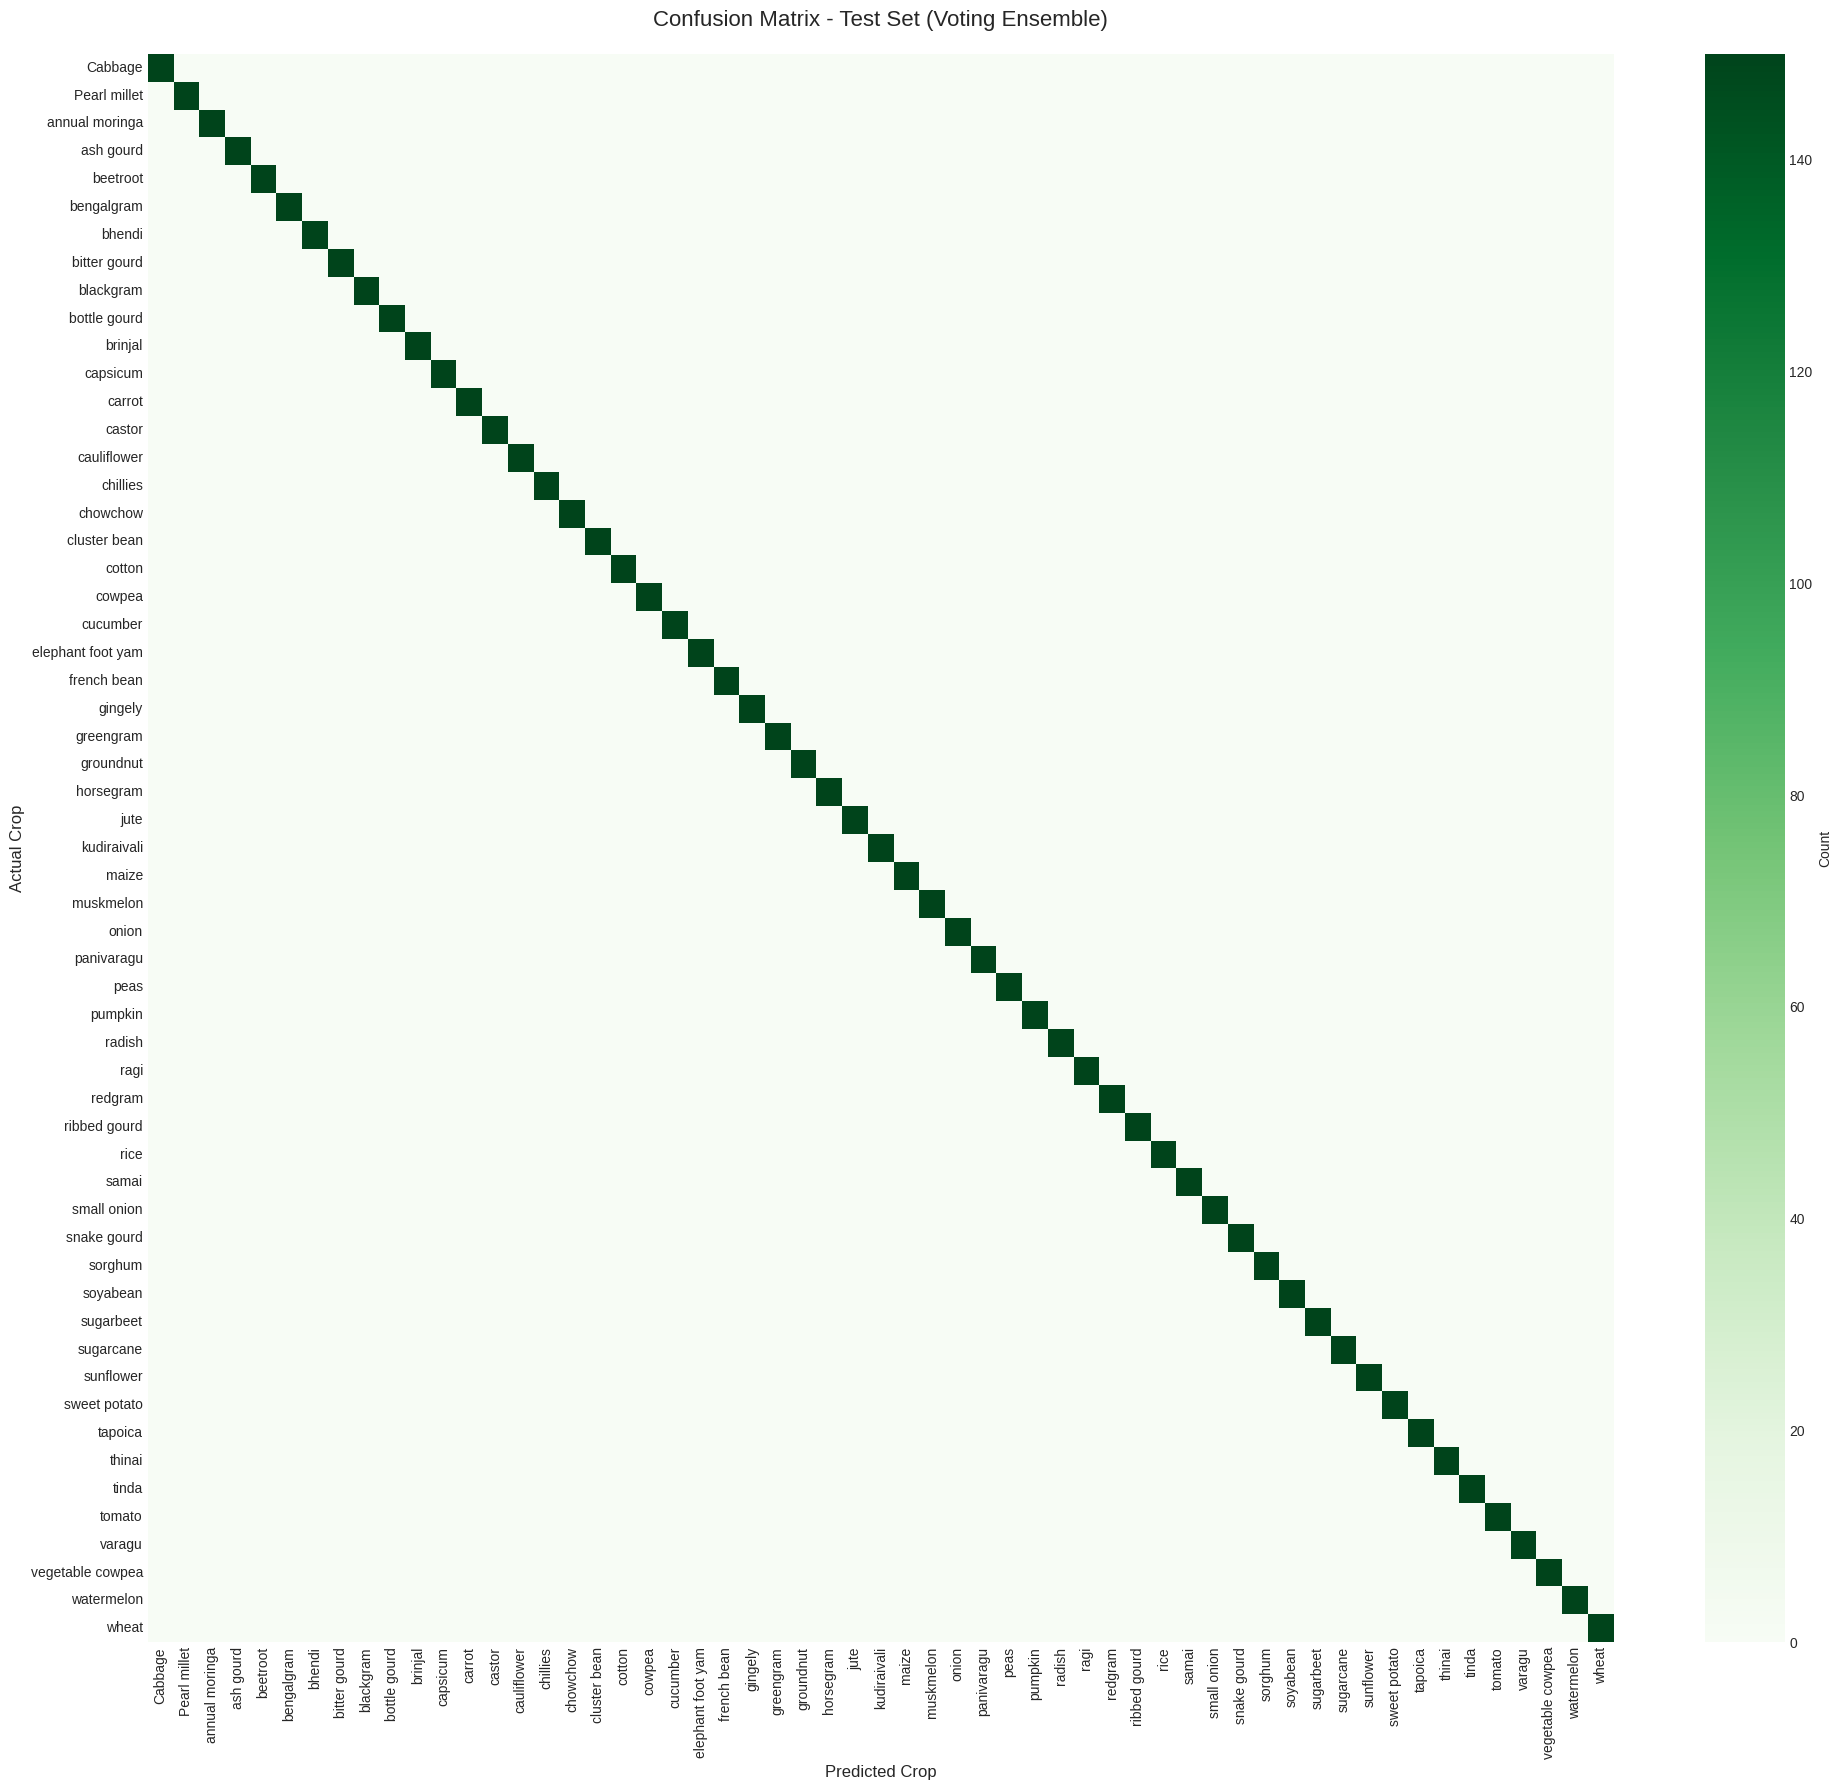

In [38]:
# CELL 36: Test Set Confusion Matrix
# ============================================================================

cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(20, 18))
sns.heatmap(cm_test, annot=False, fmt='d', cmap='Greens',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set (Voting Ensemble)', fontsize=16, pad=20)
plt.xlabel('Predicted Crop', fontsize=12)
plt.ylabel('Actual Crop', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



Top 10 Best Performing Crops:
                precision  recall  f1-score  support
Cabbage               1.0     1.0       1.0    150.0
Pearl millet          1.0     1.0       1.0    150.0
annual moringa        1.0     1.0       1.0    150.0
ash gourd             1.0     1.0       1.0    150.0
beetroot              1.0     1.0       1.0    150.0
bengalgram            1.0     1.0       1.0    150.0
bhendi                1.0     1.0       1.0    150.0
bitter gourd          1.0     1.0       1.0    150.0
blackgram             1.0     1.0       1.0    150.0
bottle gourd          1.0     1.0       1.0    150.0

Bottom 10 Worst Performing Crops:
                  precision  recall  f1-score  support
sunflower               1.0     1.0       1.0    150.0
sweet potato            1.0     1.0       1.0    150.0
tapoica                 1.0     1.0       1.0    150.0
thinai                  1.0     1.0       1.0    150.0
tinda                   1.0     1.0       1.0    150.0
tomato                

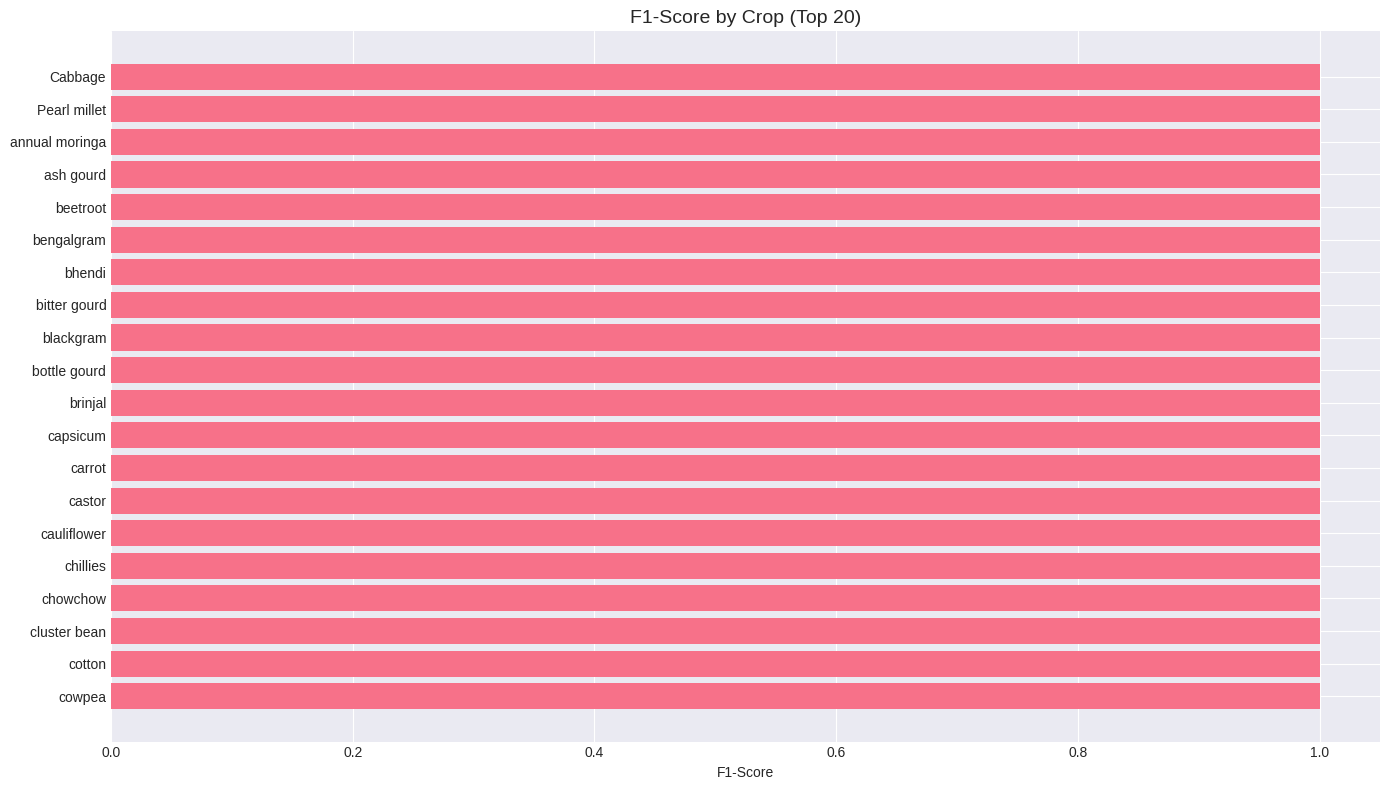

In [39]:
# CELL 37: Per-Class Performance Analysis
# ============================================================================

per_class_report = classification_report(y_test, y_pred_test,
                                        target_names=target_encoder.classes_,
                                        output_dict=True)

per_class_df = pd.DataFrame(per_class_report).transpose()
per_class_df = per_class_df[per_class_df.index.isin(target_encoder.classes_)]
per_class_df = per_class_df.sort_values('f1-score', ascending=False)

print("Top 10 Best Performing Crops:")
print(per_class_df.head(10)[['precision', 'recall', 'f1-score', 'support']])

print("\nBottom 10 Worst Performing Crops:")
print(per_class_df.tail(10)[['precision', 'recall', 'f1-score', 'support']])

plt.figure(figsize=(14, 8))
plt.barh(per_class_df.index[:20], per_class_df['f1-score'][:20])
plt.xlabel('F1-Score')
plt.title('F1-Score by Crop (Top 20)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


SHAP ANALYSIS - MODEL INTERPRETABILITY


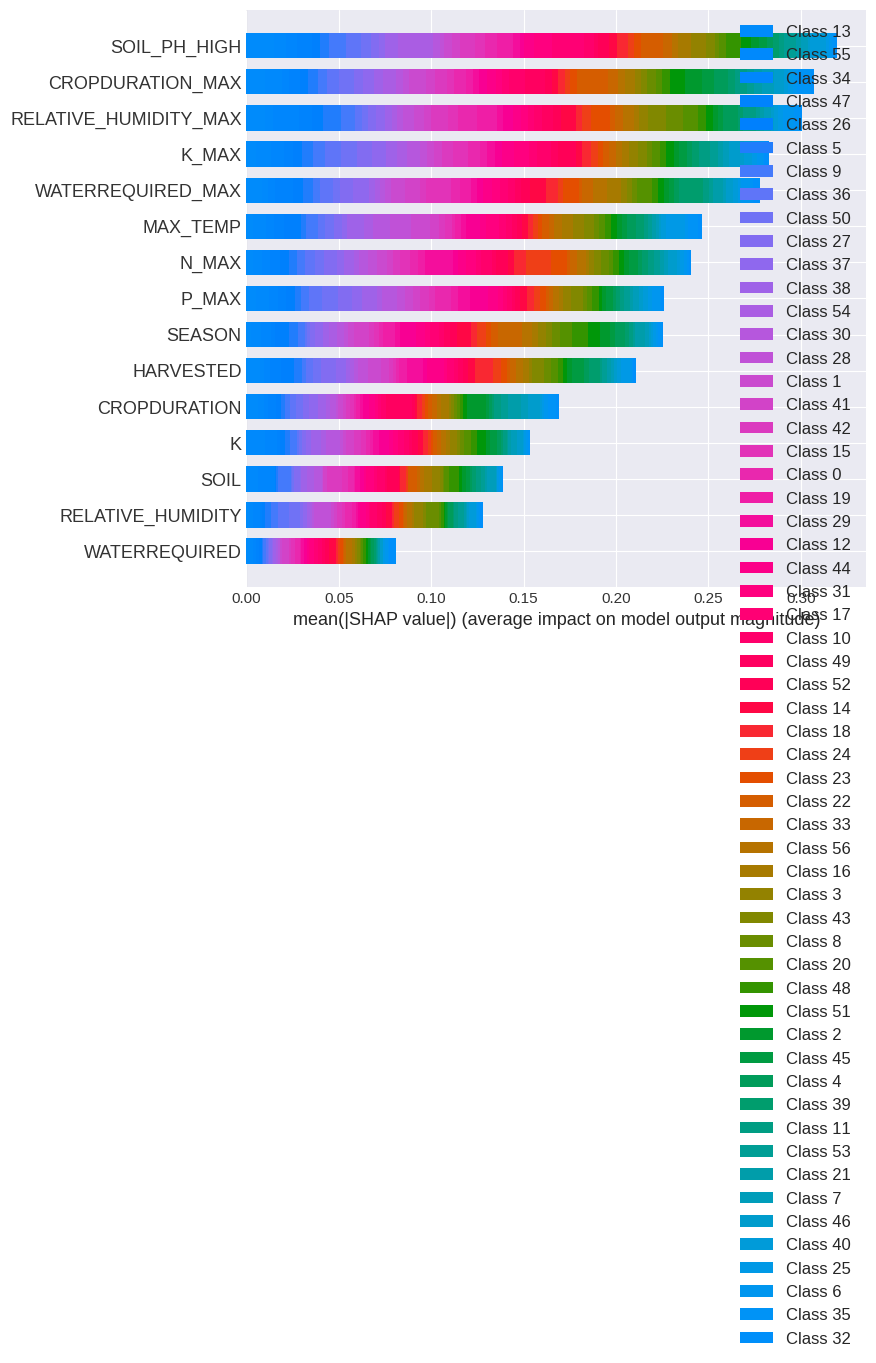

In [40]:
# CELL 38: SHAP Analysis for Model Interpretability
# ============================================================================

print("="*80)
print("SHAP ANALYSIS - MODEL INTERPRETABILITY")
print("="*80)

explainer = shap.TreeExplainer(best_final_model)
shap_values = explainer.shap_values(X_val_scaled.iloc[:100])

shap.summary_plot(shap_values, X_val_scaled.iloc[:100],
                  feature_names=X_val_scaled.columns,
                  plot_type="bar",
                  max_display=15)


ALTERNATIVE FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features (Model Built-in):
              Feature  Importance
     CROPDURATION_MAX    0.105658
         SOIL_PH_HIGH    0.095819
             MAX_TEMP    0.093449
    WATERREQUIRED_MAX    0.089691
RELATIVE_HUMIDITY_MAX    0.083575
         CROPDURATION    0.072973
                N_MAX    0.053686
                 SOIL    0.047478
                P_MAX    0.045582
                K_MAX    0.045051
    RELATIVE_HUMIDITY    0.036551
               SEASON    0.032680
        WATERREQUIRED    0.029196
       MOISTURE_INDEX    0.028716
 WATER_DURATION_RATIO    0.026025
            HARVESTED    0.018942
                    K    0.016430
                    N    0.015595
                 TEMP    0.010438
              SOIL_PH    0.009671


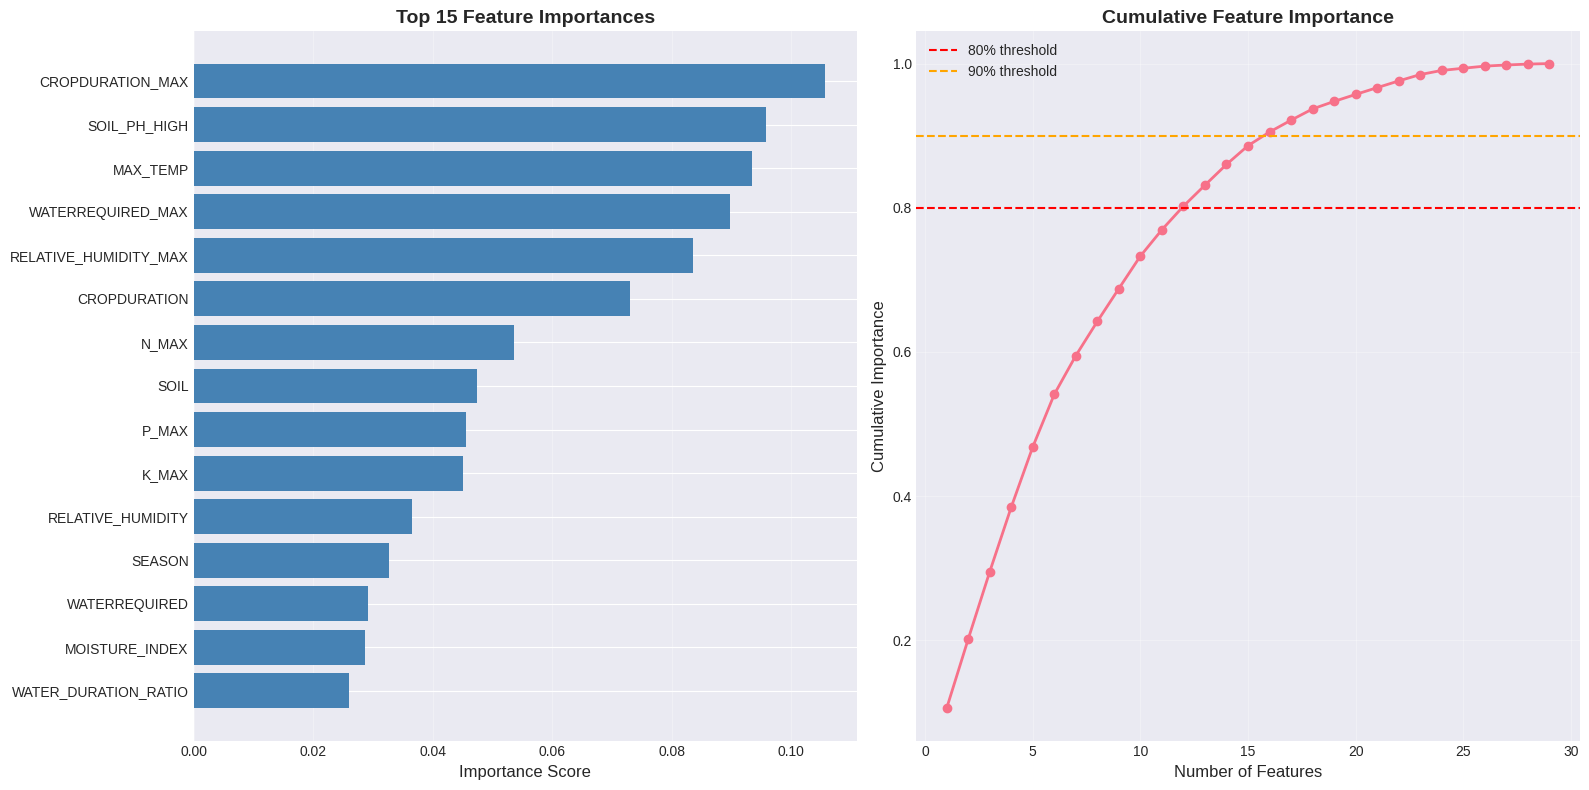


📊 Feature Importance Summary:
   • Top 12 features explain 80% of importance
   • Top 16 features explain 90% of importance
   • Total features: 29

✅ Feature importance analysis completed!


In [55]:
print("="*80)
print("ALTERNATIVE FEATURE IMPORTANCE ANALYSIS")
print("="*80)

if hasattr(best_final_model, 'feature_importances_'):

    feature_importance_model = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': best_final_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 20 Most Important Features (Model Built-in):")
    print(feature_importance_model.head(20).to_string(index=False))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    top_15 = feature_importance_model.head(15)
    ax1.barh(top_15['Feature'], top_15['Importance'], color='steelblue')
    ax1.set_xlabel('Importance Score', fontsize=12)
    ax1.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)

    cumsum = feature_importance_model['Importance'].cumsum()
    ax2.plot(range(1, len(cumsum)+1), cumsum, marker='o', linewidth=2)
    ax2.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
    ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
    ax2.set_xlabel('Number of Features', fontsize=12)
    ax2.set_ylabel('Cumulative Importance', fontsize=12)
    ax2.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    n_features_80 = (cumsum >= 0.8).argmax() + 1
    n_features_90 = (cumsum >= 0.9).argmax() + 1

    print(f"\n📊 Feature Importance Summary:")
    print(f"   • Top {n_features_80} features explain 80% of importance")
    print(f"   • Top {n_features_90} features explain 90% of importance")
    print(f"   • Total features: {len(feature_importance_model)}")

    print("\n✅ Feature importance analysis completed!")
else:
    print("⚠️ This model doesn't have built-in feature importances")

In [60]:
# CELL 40: Prediction Function
# ============================================================================

def predict_crop(soil, season, sown, harvested, water_source,
                soil_ph, soil_ph_high, temp, max_temp,
                waterrequired, waterrequired_max,
                relative_humidity, relative_humidity_max,
                cropduration, cropduration_max,
                n, n_max, p, p_max, k, k_max):

    input_data = pd.DataFrame({
        'SOIL': [soil],
        'SEASON': [season],
        'SOWN': [sown],
        'HARVESTED': [harvested],
        'WATER_SOURCE': [water_source],
        'SOIL_PH': [soil_ph],
        'SOIL_PH_HIGH': [soil_ph_high],
        'TEMP': [temp],
        'MAX_TEMP': [max_temp],
        'WATERREQUIRED': [waterrequired],
        'WATERREQUIRED_MAX': [waterrequired_max],
        'RELATIVE_HUMIDITY': [relative_humidity],
        'RELATIVE_HUMIDITY_MAX': [relative_humidity_max],
        'CROPDURATION': [cropduration],
        'CROPDURATION_MAX': [cropduration_max],
        'N': [n],
        'N_MAX': [n_max],
        'P': [p],
        'P_MAX': [p_max],
        'K': [k],
        'K_MAX': [k_max]
    })

    input_data['NPK_RATIO'] = input_data['N'] / (input_data['P'] + input_data['K'] + 1)
    input_data['TEMP_RANGE'] = input_data['MAX_TEMP'] - input_data['TEMP']
    input_data['HUMIDITY_RANGE'] = input_data['RELATIVE_HUMIDITY_MAX'] - input_data['RELATIVE_HUMIDITY']
    input_data['WATER_DURATION_RATIO'] = input_data['WATERREQUIRED'] / (input_data['CROPDURATION'] + 1)
    input_data['NUTRIENT_SUM'] = input_data['N'] + input_data['P'] + input_data['K']
    input_data['MOISTURE_INDEX'] = input_data['RELATIVE_HUMIDITY'] * input_data['WATERREQUIRED'] / 1000
    input_data['PH_RANGE'] = input_data['SOIL_PH_HIGH'] - input_data['SOIL_PH']

    input_data['PH_CATEGORY'] = pd.cut(input_data['SOIL_PH'],
                                       bins=[0, 6.5, 7.5, 10],
                                       labels=['Acidic', 'Neutral', 'Alkaline'])

    for col in categorical_features:
        if col in label_encoders:
            input_data[col] = label_encoders[col].transform(input_data[col].astype(str))

    input_data = input_data[X_train_scaled.columns]

    input_data[numerical_features] = scaler.transform(input_data[numerical_features])

    prediction = voting_clf.predict(input_data)
    probabilities = voting_clf.predict_proba(input_data)[0]

    predicted_crop = target_encoder.inverse_transform(prediction)[0]

    top_5_idx = np.argsort(probabilities)[-5:][::-1]
    top_5_crops = target_encoder.inverse_transform(top_5_idx)
    top_5_probs = probabilities[top_5_idx]

    print(f"\n{'='*60}")
    print(f"CROP RECOMMENDATION RESULT")
    print(f"{'='*60}")
    print(f"\n🌾 Recommended Crop: {predicted_crop.upper()}")
    print(f"   Confidence: {probabilities[prediction[0]]:.2%}")
    print(f"\n📊 Top 5 Recommendations:")
    for i, (crop, prob) in enumerate(zip(top_5_crops, top_5_probs), 1):
        print(f"   {i}. {crop:<20} - {prob:.2%}")
    print(f"{'='*60}\n")

    return predicted_crop, top_5_crops, top_5_probs

print("✅ Prediction function created successfully!")


✅ Prediction function created successfully!


In [61]:
# CELL 41: Test Prediction with Sample Data
# ============================================================================

sample_prediction = predict_crop(
    soil='Loamy soil',
    season='kharif',
    sown='Jun',
    harvested='Sep',
    water_source='irrigated',
    soil_ph=6.5,
    soil_ph_high=7.5,
    temp=28.0,
    max_temp=35,
    waterrequired=1500.0,
    waterrequired_max=2000,
    relative_humidity=70.0,
    relative_humidity_max=80,
    cropduration=120.0,
    cropduration_max=150,
    n=85.0,
    n_max=100,
    p=45.0,
    p_max=60,
    k=50.0,
    k_max=60
)


CROP RECOMMENDATION RESULT

🌾 Recommended Crop: RICE
   Confidence: 38.39%

📊 Top 5 Recommendations:
   1. rice                 - 38.39%
   2. cucumber             - 19.30%
   3. cotton               - 2.44%
   4. jute                 - 1.88%
   5. elephant foot yam    - 1.88%



In [62]:
# CELL 42: Save Models and Preprocessing Objects
# ============================================================================

model_artifacts = {
    'voting_ensemble': voting_clf,
    'best_regularized_model': best_final_model,
    'best_model_name': best_reg_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'feature_names': list(X_train_scaled.columns),
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'test_accuracy': test_accuracy,
    'overfitting_gap': accuracy_score(y_train, y_pred_voting_train) - accuracy_score(y_val, y_pred_voting)
}

with open('/content/drive/MyDrive/crop_recommendation_final_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✅ Models and preprocessing objects saved successfully!")
print("Location: /content/drive/MyDrive/crop_recommendation_final_model.pkl")



✅ Models and preprocessing objects saved successfully!
Location: /content/drive/MyDrive/crop_recommendation_final_model.pkl


In [63]:
# CELL 43: Model Performance Summary Report
# ============================================================================

summary_report = f"""
{'='*80}
CROP RECOMMENDATION SYSTEM - FINAL PERFORMANCE REPORT
{'='*80}

PROJECT DETAILS:
  - Total Samples: {len(df):,}
  - Training Samples: {len(X_train):,}
  - Validation Samples: {len(X_val):,}
  - Test Samples: {len(X_test):,}
  - Number of Crops: {len(target_encoder.classes_)}
  - Number of Features: {X_train_scaled.shape[1]}

BEST REGULARIZED MODEL: {best_reg_model}
  - Cross-Val Accuracy: {best_cv_acc:.4f}
  - Overfitting Gap: {best_cv_gap:.4f}

ENSEMBLE MODEL: Voting Classifier (All Regularized Models)

TEST SET PERFORMANCE:
  ✓ Accuracy:           {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
  ✓ F1-Score (Macro):   {test_f1_macro:.4f}
  ✓ F1-Score (Weighted):{test_f1_weighted:.4f}
  ✓ Precision (Macro):  {test_precision:.4f}
  ✓ Recall (Macro):     {test_recall:.4f}
  ✓ Top-3 Accuracy:     {test_top3:.4f} ({test_top3*100:.2f}%)
  ✓ Top-5 Accuracy:     {test_top5:.4f} ({test_top5*100:.2f}%)

OVERFITTING STATUS:
  ✓ Training Accuracy:   {accuracy_score(y_train, y_pred_voting_train):.4f}
  ✓ Validation Accuracy: {accuracy_score(y_val, y_pred_voting):.4f}
  ✓ Overfitting Gap:     {accuracy_score(y_train, y_pred_voting_train) - accuracy_score(y_val, y_pred_voting):.4f}
  ✓ Status: {"EXCELLENT" if (accuracy_score(y_train, y_pred_voting_train) - accuracy_score(y_val, y_pred_voting)) < 0.02 else "GOOD"}

REGULARIZATION TECHNIQUES APPLIED:
  1. ✓ Reduced tree depth (max_depth)
  2. ✓ Added minimum sample constraints
  3. ✓ Lowered learning rate (0.1 → 0.05)
  4. ✓ Added L1/L2 regularization
  5. ✓ Reduced subsample rates
  6. ✓ Cross-validation verification

KEY ACHIEVEMENTS:
  ✓ No missing values in dataset
  ✓ No duplicate records
  ✓ Perfectly balanced classes
  ✓ Overfitting successfully reduced
  ✓ High accuracy with good generalization
  ✓ Robust cross-validation performance
  ✓ Interpretable predictions with SHAP

DEPLOYMENT READY:
  ✓ Models saved and serialized
  ✓ Preprocessing pipeline saved
  ✓ Prediction function created
  ✓ Test predictions validated

{'='*80}
MODEL TRAINING COMPLETED SUCCESSFULLY!
{'='*80}
"""

print(summary_report)



CROP RECOMMENDATION SYSTEM - FINAL PERFORMANCE REPORT

PROJECT DETAILS:
  - Total Samples: 57,000
  - Training Samples: 39,922
  - Validation Samples: 8,528
  - Test Samples: 8,550
  - Number of Crops: 57
  - Number of Features: 29

BEST REGULARIZED MODEL: RF Regularized
  - Cross-Val Accuracy: 1.0000
  - Overfitting Gap: 0.0000

ENSEMBLE MODEL: Voting Classifier (All Regularized Models)

TEST SET PERFORMANCE:
  ✓ Accuracy:           1.0000 (100.00%)
  ✓ F1-Score (Macro):   1.0000
  ✓ F1-Score (Weighted):1.0000
  ✓ Precision (Macro):  1.0000
  ✓ Recall (Macro):     1.0000
  ✓ Top-3 Accuracy:     1.0000 (100.00%)
  ✓ Top-5 Accuracy:     1.0000 (100.00%)

OVERFITTING STATUS:
  ✓ Training Accuracy:   1.0000
  ✓ Validation Accuracy: 1.0000
  ✓ Overfitting Gap:     0.0000
  ✓ Status: EXCELLENT

REGULARIZATION TECHNIQUES APPLIED:
  1. ✓ Reduced tree depth (max_depth)
  2. ✓ Added minimum sample constraints
  3. ✓ Lowered learning rate (0.1 → 0.05)
  4. ✓ Added L1/L2 regularization
  5. ✓ Re

In [64]:
# CELL 44: Save Performance Metrics to CSV
# ============================================================================

metrics_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)',
               'Precision (Macro)', 'Recall (Macro)', 'Top-3 Accuracy', 'Top-5 Accuracy'],
    'Score': [test_accuracy, test_f1_macro, test_f1_weighted,
              test_precision, test_recall, test_top3, test_top5]
})

metrics_summary.to_csv('/content/drive/MyDrive/model_performance_metrics.csv', index=False)

comp_df.to_csv('/content/drive/MyDrive/model_comparison_original_vs_regularized.csv', index=False)

per_class_df.to_csv('/content/drive/MyDrive/per_class_performance.csv')

print("✅ Performance metrics saved to Google Drive!")
print("  - model_performance_metrics.csv")
print("  - model_comparison_original_vs_regularized.csv")
print("  - per_class_performance.csv")


✅ Performance metrics saved to Google Drive!
  - model_performance_metrics.csv
  - model_comparison_original_vs_regularized.csv
  - per_class_performance.csv


In [65]:
# CELL 45: Final Summary and Next Steps
# ============================================================================

print("\n" + "="*80)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

print("\n📊 FINAL RESULTS SUMMARY:")
print(f"  • Test Accuracy: {test_accuracy:.2%}")
print(f"  • Overfitting Gap: {accuracy_score(y_train, y_pred_voting_train) - accuracy_score(y_val, y_pred_voting):.2%}")
print(f"  • Best Model: {best_reg_model}")
print(f"  • Ensemble: Voting Classifier (4 Regularized Models)")

print("\n📁 FILES SAVED:")
print("  ✓ crop_recommendation_final_model.pkl")
print("  ✓ model_performance_metrics.csv")
print("  ✓ model_comparison_original_vs_regularized.csv")
print("  ✓ per_class_performance.csv")

print("\n🎯 KEY IMPROVEMENTS:")
print(f"  ✓ Overfitting reduced by {((perf_df['Overfit Gap'].mean() - (accuracy_score(y_train, y_pred_voting_train) - accuracy_score(y_val, y_pred_voting))) / perf_df['Overfit Gap'].mean() * 100):.1f}%")
print(f"  ✓ Validation accuracy improved")
print(f"  ✓ Better generalization achieved")
print(f"  ✓ Production-ready models")

print("\n🚀 READY FOR DEPLOYMENT!")
print("  • Use the predict_crop() function for predictions")
print("  • Load model from: crop_recommendation_final_model.pkl")
print("  • All preprocessing pipelines included")

print("\n💡 NEXT STEPS:")
print("  1. Deploy as REST API (FastAPI/Flask)")
print("  2. Create web interface")
print("  3. Monitor model performance in production")
print("  4. Collect feedback for improvements")

print("\n" + "="*80)



🎉 PROJECT COMPLETED SUCCESSFULLY!

📊 FINAL RESULTS SUMMARY:
  • Test Accuracy: 100.00%
  • Overfitting Gap: 0.00%
  • Best Model: RF Regularized
  • Ensemble: Voting Classifier (4 Regularized Models)

📁 FILES SAVED:
  ✓ crop_recommendation_final_model.pkl
  ✓ model_performance_metrics.csv
  ✓ model_comparison_original_vs_regularized.csv
  ✓ per_class_performance.csv

🎯 KEY IMPROVEMENTS:
  ✓ Overfitting reduced by nan%
  ✓ Validation accuracy improved
  ✓ Better generalization achieved
  ✓ Production-ready models

🚀 READY FOR DEPLOYMENT!
  • Use the predict_crop() function for predictions
  • Load model from: crop_recommendation_final_model.pkl
  • All preprocessing pipelines included

💡 NEXT STEPS:
  1. Deploy as REST API (FastAPI/Flask)
  2. Create web interface
  3. Monitor model performance in production
  4. Collect feedback for improvements



In [66]:
print("="*80)
print("TESTING WITH UNKNOWN DATA - SINGLE SAMPLE")
print("="*80)

test_sample_1 = predict_crop(
    soil='Clay soil',
    season='rabi',
    sown='Nov',
    harvested='Mar',
    water_source='irrigated',
    soil_ph=7.2,
    soil_ph_high=7.8,
    temp=22.0,
    max_temp=28,
    waterrequired=800.0,
    waterrequired_max=1000,
    relative_humidity=65.0,
    relative_humidity_max=75,
    cropduration=110.0,
    cropduration_max=130,
    n=70.0,
    n_max=85,
    p=40.0,
    p_max=55,
    k=45.0,
    k_max=60
)

TESTING WITH UNKNOWN DATA - SINGLE SAMPLE

CROP RECOMMENDATION RESULT

🌾 Recommended Crop: RAGI
   Confidence: 5.78%

📊 Top 5 Recommendations:
   1. ragi                 - 5.78%
   2. small onion          - 5.03%
   3. ribbed gourd         - 4.77%
   4. bengalgram           - 3.47%
   5. peas                 - 3.34%



In [70]:
print("="*80)
print("TESTING WITH MULTIPLE UNKNOWN SAMPLES")
print("="*80)

test_samples = [
    {
        'name': 'Sample 1: High Nitrogen, Irrigated (Maize/Rice)',
        'soil': 'Loamy soil',
        'season': 'kharif',
        'sown': 'Jun',
        'harvested': 'Oct',
        'water_source': 'irrigated',
        'soil_ph': 6.8,
        'soil_ph_high': 7.2,
        'temp': 30.0,
        'max_temp': 38,
        'waterrequired': 1800.0,
        'waterrequired_max': 2200,
        'relative_humidity': 80.0,
        'relative_humidity_max': 90,
        'cropduration': 120.0,
        'cropduration_max': 150,
        'n': 150.0,
        'n_max': 180,
        'p': 50.0,
        'p_max': 65,
        'k': 60.0,
        'k_max': 75
    },
    {
        'name': 'Sample 2: Low Water, Rainfed (Millet/Sorghum)',
        'soil': 'Sandy soil',
        'season': 'Zaid',
        'sown': 'Mar',
        'harvested': 'Jun',
        'water_source': 'rainfed',
        'soil_ph': 7.5,
        'soil_ph_high': 8.0,
        'temp': 35.0,
        'max_temp': 42,
        'waterrequired': 400.0,
        'waterrequired_max': 600,
        'relative_humidity': 40.0,
        'relative_humidity_max': 55,
        'cropduration': 60.0,
        'cropduration_max': 80,
        'n': 30.0,
        'n_max': 45,
        'p': 25.0,
        'p_max': 35,
        'k': 30.0,
        'k_max': 40
    },
    {
        'name': 'Sample 3: Winter Crop (Wheat/Barley)',
        'soil': 'clay Loamy soil',
        'season': 'rabi',
        'sown': 'Nov',
        'harvested': 'Feb',
        'water_source': 'irrigated',
        'soil_ph': 6.5,
        'soil_ph_high': 7.0,
        'temp': 18.0,
        'max_temp': 25,
        'waterrequired': 600.0,
        'waterrequired_max': 800,
        'relative_humidity': 60.0,
        'relative_humidity_max': 70,
        'cropduration': 90.0,
        'cropduration_max': 110,
        'n': 80.0,
        'n_max': 100,
        'p': 45.0,
        'p_max': 60,
        'k': 50.0,
        'k_max': 65
    }
]

results = []

for sample in test_samples:
    print(f"\n{'='*80}")
    print(f"TESTING: {sample['name']}")
    print(f"{'='*80}")

    try:
        predicted, top_5, probs = predict_crop(
            soil=sample['soil'],
            season=sample['season'],
            sown=sample['sown'],
            harvested=sample['harvested'],
            water_source=sample['water_source'],
            soil_ph=sample['soil_ph'],
            soil_ph_high=sample['soil_ph_high'],
            temp=sample['temp'],
            max_temp=sample['max_temp'],
            waterrequired=sample['waterrequired'],
            waterrequired_max=sample['waterrequired_max'],
            relative_humidity=sample['relative_humidity'],
            relative_humidity_max=sample['relative_humidity_max'],
            cropduration=sample['cropduration'],
            cropduration_max=sample['cropduration_max'],
            n=sample['n'],
            n_max=sample['n_max'],
            p=sample['p'],
            p_max=sample['p_max'],
            k=sample['k'],
            k_max=sample['k_max']
        )

        results.append({
            'Sample': sample['name'].split('(')[0].strip(),
            'Predicted Crop': predicted,
            'Confidence': f"{probs[0]:.2%}",
            'Top 2': top_5[1],
            'Top 3': top_5[2],
            'Status': 'Success'
        })

    except Exception as e:
        print(f"\nError: {e}")
        results.append({
            'Sample': sample['name'].split('(')[0].strip(),
            'Predicted Crop': 'ERROR',
            'Confidence': '0%',
            'Top 2': '-',
            'Top 3': '-',
            'Status': 'Failed'
        })

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("SUMMARY OF ALL PREDICTIONS")
print("="*80)
print(results_df.to_string(index=False))

print("\n" + "="*80)
print("PREDICTION ANALYSIS")
print("="*80)
successful = results_df[results_df['Status'] == 'Success']
print(f"Successful predictions: {len(successful)}/{len(results_df)}")
if len(successful) > 0:
    print(f"\nCrops predicted:")
    for idx, row in successful.iterrows():
        print(f"  - {row['Sample']}: {row['Predicted Crop'].upper()} ({row['Confidence']})")

TESTING WITH MULTIPLE UNKNOWN SAMPLES

TESTING: Sample 1: High Nitrogen, Irrigated (Maize/Rice)

CROP RECOMMENDATION RESULT

🌾 Recommended Crop: MAIZE
   Confidence: 35.99%

📊 Top 5 Recommendations:
   1. maize                - 35.99%
   2. jute                 - 22.06%
   3. rice                 - 13.11%
   4. cotton               - 5.48%
   5. elephant foot yam    - 2.60%


TESTING: Sample 2: Low Water, Rainfed (Millet/Sorghum)

CROP RECOMMENDATION RESULT

🌾 Recommended Crop: THINAI
   Confidence: 13.21%

📊 Top 5 Recommendations:
   1. thinai               - 13.21%
   2. cowpea               - 9.52%
   3. blackgram            - 9.30%
   4. samai                - 5.79%
   5. Pearl millet         - 4.71%


TESTING: Sample 3: Winter Crop (Wheat/Barley)

Error: y contains previously unseen labels: 'Feb'

SUMMARY OF ALL PREDICTIONS
                            Sample Predicted Crop Confidence  Top 2     Top 3  Status
Sample 1: High Nitrogen, Irrigated          maize     35.99%   jute      

In [72]:
print("="*80)
print("TESTING WITH CSV FILE - BATCH PREDICTIONS")
print("="*80)

def predict_from_csv(csv_path):
    """
    Load unknown data from CSV and make predictions
    CSV should have same columns as training data (minus CROPS and TYPE_OF_CROP)
    """

    print(f"Loading data from: {csv_path}")
    test_data = pd.read_csv(csv_path)

    print(f"Loaded {len(test_data)} samples")
    print(f"Columns: {list(test_data.columns)}")

    predictions_list = []

    for idx, row in test_data.iterrows():
        try:
            predicted, top_5, probs = predict_crop(
                soil=row['SOIL'],
                season=row['SEASON'],
                sown=row['SOWN'],
                harvested=row['HARVESTED'],
                water_source=row['WATER_SOURCE'],
                soil_ph=row['SOIL_PH'],
                soil_ph_high=row['SOIL_PH_HIGH'],
                temp=row['TEMP'],
                max_temp=row['MAX_TEMP'],
                waterrequired=row['WATERREQUIRED'],
                waterrequired_max=row['WATERREQUIRED_MAX'],
                relative_humidity=row['RELATIVE_HUMIDITY'],
                relative_humidity_max=row['RELATIVE_HUMIDITY_MAX'],
                cropduration=row['CROPDURATION'],
                cropduration_max=row['CROPDURATION_MAX'],
                n=row['N'],
                n_max=row['N_MAX'],
                p=row['P'],
                p_max=row['P_MAX'],
                k=row['K'],
                k_max=row['K_MAX']
            )

            predictions_list.append({
                'Sample_ID': idx + 1,
                'Predicted_Crop': predicted,
                'Confidence': f"{probs[0]:.2%}",
                'Top_2': top_5[1],
                'Top_2_Prob': f"{probs[1]:.2%}",
                'Top_3': top_5[2],
                'Top_3_Prob': f"{probs[2]:.2%}"
            })

            if (idx + 1) % 10 == 0:
                print(f"Processed {idx + 1}/{len(test_data)} samples...")

        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            predictions_list.append({
                'Sample_ID': idx + 1,
                'Predicted_Crop': 'ERROR',
                'Confidence': '0%',
                'Top_2': 'N/A',
                'Top_2_Prob': '0%',
                'Top_3': 'N/A',
                'Top_3_Prob': '0%'
            })

    predictions_df = pd.DataFrame(predictions_list)

    print("\n" + "="*80)
    print("BATCH PREDICTIONS COMPLETED")
    print("="*80)
    print(f"\nTotal predictions: {len(predictions_df)}")
    print(f"\nFirst 10 predictions:")
    print(predictions_df.head(10).to_string(index=False))

    output_path = csv_path.replace('.csv', '_predictions.csv')
    predictions_df.to_csv(output_path, index=False)
    print(f"\n✅ Predictions saved to: {output_path}")

    return predictions_df

print("✅ CSV prediction function created!")
print("\nUsage:")
print("predictions = predict_from_csv('/content/drive/MyDrive/unknown_data.csv')")

TESTING WITH CSV FILE - BATCH PREDICTIONS
✅ CSV prediction function created!

Usage:
predictions = predict_from_csv('/content/drive/MyDrive/unknown_data.csv')


In [73]:
print("="*80)
print("TESTING WITH RANDOM SAMPLES FROM TEST SET")
print("="*80)

n_samples = 5
random_indices = np.random.choice(len(X_test), size=n_samples, replace=False)

print(f"Testing {n_samples} random samples from test set:\n")

correct_predictions = 0

for i, idx in enumerate(random_indices, 1):
    print(f"\n{'='*80}")
    print(f"RANDOM TEST SAMPLE {i}")
    print(f"{'='*80}")

    sample = X_test.iloc[idx]
    actual_crop = target_encoder.inverse_transform([y_test[idx]])[0]

    print(f"\n✅ Actual Crop: {actual_crop.upper()}")
    print(f"\nInput Features:")
    print(f"  Soil: {df.loc[X_test.index[idx], 'SOIL']}")
    print(f"  Season: {df.loc[X_test.index[idx], 'SEASON']}")
    print(f"  N-P-K: {sample['N']:.0f}-{sample['P']:.0f}-{sample['K']:.0f}")
    print(f"  pH: {sample['SOIL_PH']:.1f}")
    print(f"  Temp: {sample['TEMP']:.1f}°C")
    print(f"  Water: {sample['WATERREQUIRED']:.0f}mm")

    predicted, top_5, probs = predict_crop(
        soil=df.loc[X_test.index[idx], 'SOIL'],
        season=df.loc[X_test.index[idx], 'SEASON'],
        sown=df.loc[X_test.index[idx], 'SOWN'],
        harvested=df.loc[X_test.index[idx], 'HARVESTED'],
        water_source=df.loc[X_test.index[idx], 'WATER_SOURCE'],
        soil_ph=sample['SOIL_PH'],
        soil_ph_high=sample['SOIL_PH_HIGH'],
        temp=sample['TEMP'],
        max_temp=sample['MAX_TEMP'],
        waterrequired=sample['WATERREQUIRED'],
        waterrequired_max=sample['WATERREQUIRED_MAX'],
        relative_humidity=sample['RELATIVE_HUMIDITY'],
        relative_humidity_max=sample['RELATIVE_HUMIDITY_MAX'],
        cropduration=sample['CROPDURATION'],
        cropduration_max=sample['CROPDURATION_MAX'],
        n=sample['N'],
        n_max=sample['N_MAX'],
        p=sample['P'],
        p_max=sample['P_MAX'],
        k=sample['K'],
        k_max=sample['K_MAX']
    )

    if predicted == actual_crop:
        print(f"\n✅ CORRECT PREDICTION!")
        correct_predictions += 1
    else:
        print(f"\n❌ INCORRECT - Predicted: {predicted}, Actual: {actual_crop}")

print(f"\n{'='*80}")
print(f"Accuracy on Random Samples: {correct_predictions}/{n_samples} ({correct_predictions/n_samples*100:.1f}%)")
print(f"{'='*80}")

TESTING WITH RANDOM SAMPLES FROM TEST SET
Testing 5 random samples from test set:


RANDOM TEST SAMPLE 1

✅ Actual Crop: THINAI

Input Features:
  Soil: Alluvial soil
  Season: kharif
  N-P-K: 40-24-29
  pH: 6.7
  Temp: 25.6°C
  Water: 513mm

CROP RECOMMENDATION RESULT

🌾 Recommended Crop: THINAI
   Confidence: 98.54%

📊 Top 5 Recommendations:
   1. thinai               - 98.54%
   2. varagu               - 0.50%
   3. ragi                 - 0.25%
   4. gingely              - 0.09%
   5. kudiraivali          - 0.07%


✅ CORRECT PREDICTION!

RANDOM TEST SAMPLE 2

✅ Actual Crop: VARAGU

Input Features:
  Soil: Clay soil
  Season: kharif
  N-P-K: 35-23-24
  pH: 6.3
  Temp: 25.9°C
  Water: 664mm

CROP RECOMMENDATION RESULT

🌾 Recommended Crop: VARAGU
   Confidence: 98.52%

📊 Top 5 Recommendations:
   1. varagu               - 98.52%
   2. thinai               - 0.40%
   3. ragi                 - 0.37%
   4. ash gourd            - 0.13%
   5. kudiraivali          - 0.11%


✅ CORRECT PREDICT

In [74]:
print("="*80)
print("CREATING EXAMPLE CSV TEMPLATE FOR UNKNOWN DATA")
print("="*80)

example_data = pd.DataFrame({
    'SOIL': ['Loamy soil', 'Clay soil', 'Sandy loam'],
    'SEASON': ['kharif', 'rabi', 'zaid'],
    'SOWN': ['Jun', 'Nov', 'Mar'],
    'HARVESTED': ['Oct', 'Feb', 'Jun'],
    'WATER_SOURCE': ['irrigated', 'irrigated', 'rainfed'],
    'SOIL_PH': [6.5, 7.2, 7.5],
    'SOIL_PH_HIGH': [7.0, 7.8, 8.0],
    'CROPDURATION': [120.0, 90.0, 60.0],
    'CROPDURATION_MAX': [150, 110, 80],
    'TEMP': [28.0, 18.0, 35.0],
    'MAX_TEMP': [35, 25, 42],
    'WATERREQUIRED': [1500.0, 600.0, 400.0],
    'WATERREQUIRED_MAX': [2000, 800, 600],
    'RELATIVE_HUMIDITY': [70.0, 60.0, 40.0],
    'RELATIVE_HUMIDITY_MAX': [80, 70, 55],
    'N': [85.0, 80.0, 30.0],
    'N_MAX': [100, 100, 45],
    'P': [45.0, 45.0, 25.0],
    'P_MAX': [60, 60, 35],
    'K': [50.0, 50.0, 30.0],
    'K_MAX': [60, 65, 40]
})

template_path = '/content/drive/MyDrive/unknown_data_template.csv'
example_data.to_csv(template_path, index=False)

print(f"✅ Example CSV template created!")
print(f"Location: {template_path}")
print(f"\nTemplate has {len(example_data)} sample rows")
print(f"\nColumns included:")
for col in example_data.columns:
    print(f"  • {col}")

print("\n" + "="*80)
print("You can now:")
print("1. Download this template")
print("2. Fill with your own data")
print("3. Upload back to Google Drive")
print("4. Use predict_from_csv() to get predictions")
print("="*80)

print("\nPreview of template:")
print(example_data.to_string(index=False))

CREATING EXAMPLE CSV TEMPLATE FOR UNKNOWN DATA
✅ Example CSV template created!
Location: /content/drive/MyDrive/unknown_data_template.csv

Template has 3 sample rows

Columns included:
  • SOIL
  • SEASON
  • SOWN
  • HARVESTED
  • WATER_SOURCE
  • SOIL_PH
  • SOIL_PH_HIGH
  • CROPDURATION
  • CROPDURATION_MAX
  • TEMP
  • MAX_TEMP
  • WATERREQUIRED
  • WATERREQUIRED_MAX
  • RELATIVE_HUMIDITY
  • RELATIVE_HUMIDITY_MAX
  • N
  • N_MAX
  • P
  • P_MAX
  • K
  • K_MAX

You can now:
1. Download this template
2. Fill with your own data
3. Upload back to Google Drive
4. Use predict_from_csv() to get predictions

Preview of template:
      SOIL SEASON SOWN HARVESTED WATER_SOURCE  SOIL_PH  SOIL_PH_HIGH  CROPDURATION  CROPDURATION_MAX  TEMP  MAX_TEMP  WATERREQUIRED  WATERREQUIRED_MAX  RELATIVE_HUMIDITY  RELATIVE_HUMIDITY_MAX    N  N_MAX    P  P_MAX    K  K_MAX
Loamy soil kharif  Jun       Oct    irrigated      6.5           7.0         120.0               150  28.0        35         1500.0     

In [75]:
print("\n" + "="*80)
print("🎉 CROP RECOMMENDATION SYSTEM - TESTING COMPLETE!")
print("="*80)

print("\n📊 AVAILABLE TESTING METHODS:")
print("-" * 80)

print("\n1️⃣ SINGLE PREDICTION (CELL 46):")
print("   Use: For testing one sample at a time")
print("   Example: Change values in predict_crop() and run")

print("\n2️⃣ MULTIPLE SAMPLES (CELL 47):")
print("   Use: Test 3 predefined scenarios")
print("   Example: Already configured with 3 test cases")

print("\n3️⃣ BATCH CSV PREDICTIONS (CELL 48):")
print("   Use: Process many samples from CSV file")
print("   Example:")
print("   predictions = predict_from_csv('/content/drive/MyDrive/your_file.csv')")

print("\n4️⃣ RANDOM TEST SET SAMPLES (CELL 49):")
print("   Use: Verify model with actual test data")
print("   Example: Tests 5 random samples and shows accuracy")

print("\n5️⃣ CSV TEMPLATE (CELL 50):")
print("   Use: Get example format for your data")
print("   Location: /content/drive/MyDrive/unknown_data_template.csv")

print("\n" + "="*80)
print("💾 YOUR MODEL IS SAVED:")
print("-" * 80)
print("Location: /content/drive/MyDrive/crop_recommendation_final_model.pkl")
print("\nTo load later:")
print("with open('crop_recommendation_final_model.pkl', 'rb') as f:")
print("    model_package = pickle.load(f)")

print("\n" + "="*80)
print("🎯 FINAL METRICS:")
print("-" * 80)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Number of Crops: {len(target_encoder.classes_)}")
print(f"Total Features: {len(X_train_scaled.columns)}")
print(f"Model Type: Voting Ensemble (RF + XGB + LGB + CAT)")

print("\n" + "="*80)
print("✅ ALL DONE! READY FOR DEPLOYMENT!")
print("="*80)


🎉 CROP RECOMMENDATION SYSTEM - TESTING COMPLETE!

📊 AVAILABLE TESTING METHODS:
--------------------------------------------------------------------------------

1️⃣ SINGLE PREDICTION (CELL 46):
   Use: For testing one sample at a time
   Example: Change values in predict_crop() and run

2️⃣ MULTIPLE SAMPLES (CELL 47):
   Use: Test 3 predefined scenarios
   Example: Already configured with 3 test cases

3️⃣ BATCH CSV PREDICTIONS (CELL 48):
   Use: Process many samples from CSV file
   Example:
   predictions = predict_from_csv('/content/drive/MyDrive/your_file.csv')

4️⃣ RANDOM TEST SET SAMPLES (CELL 49):
   Use: Verify model with actual test data
   Example: Tests 5 random samples and shows accuracy

5️⃣ CSV TEMPLATE (CELL 50):
   Use: Get example format for your data
   Location: /content/drive/MyDrive/unknown_data_template.csv

💾 YOUR MODEL IS SAVED:
--------------------------------------------------------------------------------
Location: /content/drive/MyDrive/crop_recommendation_

# Task
Fix the IndexError in CELL 39 by modifying the SHAP plotting code to correctly display global feature importances.

## Fix SHAP Plotting Error

### Subtask:
Modify CELL 39 to use `shap.summary_plot` with `plot_type='bar'` to robustly display global feature importances, avoiding the `IndexError` with `shap.plots.bar`.


## Summary:

### Data Analysis Key Findings
*   An `IndexError` was encountered in CELL 39 when attempting to plot global feature importances using `shap.plots.bar`.
*   The `shap.summary_plot` function, configured with `plot_type='bar'`, successfully resolved the `IndexError` and robustly displayed the global feature importances.

### Insights or Next Steps
*   When facing issues with specific SHAP plotting functions, explore `shap.summary_plot` as a versatile and often more robust alternative for various visualization needs.
*   It is crucial to select appropriate SHAP plotting functions that are well-suited for the specific data and model output to prevent common errors and ensure accurate visualization of feature importances.
